In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
import geopy.distance
from sklearn.pipeline import Pipeline
from datetime import timedelta 

In [2]:
df = pd.read_csv('nyc bus data.csv')
df = df.drop_duplicates()
# = df.dropna()
df.head()

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (14,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Unnamed: 17
0,6/1/2017 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,40.635170,-73.960803,FOSTER AV/E 18 ST,approaching,76,6/1/2017 0:03,24:06:14,NaN
1,6/1/2017 0:03,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,40.590802,-74.158340,MERRYMOUNT ST/TRAVIS AV,approaching,62,6/1/2017 0:03,23:58:02,NaN
2,6/1/2017 0:03,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,40.886010,-73.912647,HENRY HUDSON PKY E/W 235 ST,at stop,5,6/1/2017 0:03,24:00:53,NaN
3,6/1/2017 0:03,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,40.668002,-73.729348,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267,6/1/2017 0:04,24:03:00,NaN
4,6/1/2017 0:03,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,40.868134,-73.893032,GRAND CONCOURSE/E 196 ST,at stop,11,6/1/2017 0:03,23:59:38,NaN


In [3]:
df.shape

(1048575, 18)

In [4]:
#checking for column types and missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 18 columns):
RecordedAtTime               1048575 non-null object
DirectionRef                 1048575 non-null int64
PublishedLineName            1048575 non-null object
OriginName                   1040112 non-null object
OriginLat                    1040112 non-null float64
OriginLong                   1040112 non-null float64
DestinationName              1048575 non-null object
DestinationLat               1047329 non-null float64
DestinationLong              1047329 non-null float64
VehicleRef                   1048575 non-null object
VehicleLocation.Latitude     1048575 non-null float64
VehicleLocation.Longitude    1048575 non-null float64
NextStopPointName            1047439 non-null object
ArrivalProximityText         1047439 non-null object
DistanceFromStop             1047439 non-null object
ExpectedArrivalTime          931342 non-null object
ScheduledArrivalTime         102290

The data had several columns with missing data.  As can be seen in the next cell, I used the ffill() method to fill in the missing data.

In [5]:
#filling in missing data 
df['OriginName'].ffill(axis=0, inplace=True)
df['OriginLat'].ffill(axis=0, inplace=True)
df['OriginLong'].ffill(axis=0, inplace=True)
df['DestinationLat'].ffill(axis=0, inplace=True)
df['DestinationLong'].ffill(axis=0, inplace=True)
df['DistanceFromStop'].ffill(axis=0, inplace=True)
df['ArrivalProximityText'].ffill(axis=0, inplace=True)
df['NextStopPointName'].ffill(axis=0, inplace=True)
df['ExpectedArrivalTime'].ffill(axis=0, inplace=True)
df['ScheduledArrivalTime'].ffill(axis=0, inplace=True)


In [6]:
#examining "ExpectedArrivalTime" column
df['ExpectedArrivalTime'].head()

0    6/1/2017 0:03
1    6/1/2017 0:03
2    6/1/2017 0:03
3    6/1/2017 0:04
4    6/1/2017 0:03
Name: ExpectedArrivalTime, dtype: object

In [7]:
#examining "ScheduledArrivalTime" column
df['ScheduledArrivalTime'].head()

0    24:06:14
1    23:58:02
2    24:00:53
3    24:03:00
4    23:59:38
Name: ScheduledArrivalTime, dtype: object

The "ExpectedArrivalTime" and "ScheduledArrivalTime" columns both need to be cleaned and formatted into proper datetime columns.  The "ScheduledArrivalTime" column is missing the date, and its midnight hour needs to be properly formatted to "00".

I used the split() method to split the date and time portions of the "ExpectedArrivalTime", and save the date into a new column called "expected_date".

I then applied a lambda function to "ScheduledArrivalTime" and used the replace() method to correct the midnight hour from "24" to "00".

I will then join "expected_date" with "ScheduledArrivalTime" to create a proper datetime column.  Please see below

In [8]:
#splitting 'ExpectedArrivalTime' column
expected_split = df['ExpectedArrivalTime'].str.split(expand=True)
print(expected_split.head())

          0     1
0  6/1/2017  0:03
1  6/1/2017  0:03
2  6/1/2017  0:03
3  6/1/2017  0:04
4  6/1/2017  0:03


In [9]:
#creating new feature; the 'expected_date' column
df['expected_date'] = expected_split[0]

In [10]:
#formatting the 'ScheduledArrivalTime'
df['ScheduledArrivalTime'] = df['ScheduledArrivalTime'].apply(lambda x: x[0:2].replace('24', '00')) + df['ScheduledArrivalTime'].apply(lambda x: x[2:])

In [11]:
#examining the 'ScheduledArrivalTime' column
df['ScheduledArrivalTime'].head()

0    00:06:14
1    23:58:02
2    00:00:53
3    00:03:00
4    23:59:38
Name: ScheduledArrivalTime, dtype: object

In [12]:
#creating new feature'Scheduled_datetime' column
df['Scheduled_datetime'] = df['expected_date'] + ' ' + df['ScheduledArrivalTime']

In [13]:
#examining 'Scheduled_datetime' column
df['Scheduled_datetime'].head()

0    6/1/2017 00:06:14
1    6/1/2017 23:58:02
2    6/1/2017 00:00:53
3    6/1/2017 00:03:00
4    6/1/2017 23:59:38
Name: Scheduled_datetime, dtype: object

In [14]:
#converting 'Scheduled_datetime' to datetime object
df['Scheduled_datetime'] = pd.to_datetime(df['Scheduled_datetime'], errors='coerce')

In [15]:
#converting 'Expected_arrival' column to datetime object
df['Expected_datetime'] = pd.to_datetime(df['ExpectedArrivalTime'], errors='coerce')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
RecordedAtTime               1048575 non-null object
DirectionRef                 1048575 non-null int64
PublishedLineName            1048575 non-null object
OriginName                   1048575 non-null object
OriginLat                    1048575 non-null float64
OriginLong                   1048575 non-null float64
DestinationName              1048575 non-null object
DestinationLat               1048575 non-null float64
DestinationLong              1048575 non-null float64
VehicleRef                   1048575 non-null object
VehicleLocation.Latitude     1048575 non-null float64
VehicleLocation.Longitude    1048575 non-null float64
NextStopPointName            1048575 non-null object
ArrivalProximityText         1048575 non-null object
DistanceFromStop             1048575 non-null object
ExpectedArrivalTime          1048575 non-null object
ScheduledArrivalTime         10485

In [17]:
#filling in missing data
df['Scheduled_datetime'].ffill(axis=0, inplace=True)
df['Expected_datetime'].ffill(axis=0, inplace=True)


In [18]:
df.isnull().sum().sum()

1048516

The above null values are in the "Unnamed" column, which I will drop later

In the "Scheduled_datetime" column the actual date near the midnight hour should one day before the date listed.  I will apply a lambda function to subtract one day from the date in the datetime for all observations where the value equals '23'.  Please see below. 

In [19]:
#fixing the date value, by subtracting one day, for those datetime entries where the hour is near midnight.
df['Scheduled_datetime'] = df['Scheduled_datetime'].apply(lambda x: x - timedelta(days=1) if str(x)[11:13] == '23' else x)

In [20]:
#create new feature to record the difference between each bus's scheduled arrival time and expected arrival time.
df['delay'] = df['Expected_datetime'] - df['Scheduled_datetime']

In [21]:
df.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay
0,6/1/2017 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,FOSTER AV/E 18 ST,approaching,76,6/1/2017 0:03,00:06:14,NaN,6/1/2017,2017-06-01 00:06:14,2017-06-01 00:03:00,-1 days +23:56:46
1,6/1/2017 0:03,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,MERRYMOUNT ST/TRAVIS AV,approaching,62,6/1/2017 0:03,23:58:02,NaN,6/1/2017,2017-05-31 23:58:02,2017-06-01 00:03:00,00:04:58
2,6/1/2017 0:03,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,...,HENRY HUDSON PKY E/W 235 ST,at stop,5,6/1/2017 0:03,00:00:53,NaN,6/1/2017,2017-06-01 00:00:53,2017-06-01 00:03:00,00:02:07
3,6/1/2017 0:03,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,...,HOOK CREEK BL/SUNRISE HY,< 1 stop away,267,6/1/2017 0:04,00:03:00,NaN,6/1/2017,2017-06-01 00:03:00,2017-06-01 00:04:00,00:01:00
4,6/1/2017 0:03,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,...,GRAND CONCOURSE/E 196 ST,at stop,11,6/1/2017 0:03,23:59:38,NaN,6/1/2017,2017-05-31 23:59:38,2017-06-01 00:03:00,00:03:22


In [22]:
#creating new feature called 'Scheduled_HourOfDay', to reflect relationship of the time of day and whether or not a bus is on time.
#Certain bus routes may be effected by non controllable conditions such as traffic, which is more of a factor during rush hour
#and accounting for the hour of day may help the model capture that relationship. 
df['Scheduled_HourOfDay'] = df['Scheduled_datetime'].dt.hour

In [23]:
#creating a new feature "delay_second" to equate 'delay' column in seconds
df['delay_second'] = df['delay'].dt.seconds

In [24]:
#creating new feature 'delay_minute' to convert the delay_second to minutes
df['delay_minute'] = df['delay_second'] / 60

In [25]:
df.delay.value_counts().head(10)

00:01:00             21215
00:00:00             20973
00:02:00             19748
-1 days +23:59:00    18994
00:03:00             17457
00:04:00             15582
-1 days +23:58:00    14392
00:05:00             13712
00:06:00             12310
00:07:00             10952
Name: delay, dtype: int64

The "delay" feature in the dataset has some values that are negative in days.  To explore this further, I am going to extract the days from the "delay" column to get more insight into the data.

In [26]:
#creating new feature delay_days by extracting the day value from 'delay' column.  
df['delay_days'] = df['delay'].dt.days

In [27]:
df.head(10)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay,Scheduled_HourOfDay,delay_second,delay_minute,delay_days
0,6/1/2017 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,00:06:14,NaN,6/1/2017,2017-06-01 00:06:14,2017-06-01 00:03:00,-1 days +23:56:46,0,86206,1436.766667,-1
1,6/1/2017 0:03,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,23:58:02,NaN,6/1/2017,2017-05-31 23:58:02,2017-06-01 00:03:00,00:04:58,23,298,4.966667,0
2,6/1/2017 0:03,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,...,00:00:53,NaN,6/1/2017,2017-06-01 00:00:53,2017-06-01 00:03:00,00:02:07,0,127,2.116667,0
3,6/1/2017 0:03,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,...,00:03:00,NaN,6/1/2017,2017-06-01 00:03:00,2017-06-01 00:04:00,00:01:00,0,60,1.000000,0
4,6/1/2017 0:03,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,...,23:59:38,NaN,6/1/2017,2017-05-31 23:59:38,2017-06-01 00:03:00,00:03:22,23,202,3.366667,0
5,6/1/2017 0:03,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,...,00:02:35,NaN,6/1/2017,2017-06-01 00:02:35,2017-06-01 00:03:00,00:00:25,0,25,0.416667,0
6,6/1/2017 0:03,0,B31,GERRITSEN AV/GERRITSEN BEACH,40.587101,-73.918503,MIDWOOD KINGS HWY STA,40.608433,-73.957100,NYCT_4611,...,00:08:00,NaN,6/1/2017,2017-06-01 00:08:00,2017-06-01 00:03:00,-1 days +23:55:00,0,86100,1435.000000,-1
7,6/1/2017 0:03,0,B83,GATEWAY CTR TERM/GATEWAY DR,40.652649,-73.877029,BWAY JCT VN SNDRN AV,40.678139,-73.903572,NYCT_4841,...,23:58:47,NaN,6/1/2017,2017-05-31 23:58:47,2017-06-01 00:04:00,00:05:13,23,313,5.216667,0
8,6/1/2017 0:03,0,B82,STILLWELL TERMINAL BUS LOOP,40.577080,-73.981293,SPRING CRK TWRS SEAVIEW AV via KINGS HWY,40.642990,-73.878326,NYCT_6592,...,00:00:00,NaN,6/1/2017,2017-06-01 00:00:00,2017-06-01 00:03:00,00:03:00,0,180,3.000000,0
9,6/1/2017 0:03,1,S59,RICHMOND TER/PARK AV #3,40.640167,-74.130966,HYLAN BL,40.534260,-74.154213,NYCT_8279,...,00:01:14,NaN,6/1/2017,2017-06-01 00:01:14,2017-06-01 00:03:00,00:01:46,0,106,1.766667,0


# Data Exploration:

Next I'm going to explore the data by subsetting the data by the values of the "delay_days" column.  

In [28]:
#getting value_counts for all values for the delay_days column.
df.delay_days.value_counts()

 0        764562
-1        271111
 1         12899
-10075         2
-17377         1
Name: delay_days, dtype: int64

In [29]:
#subsetting the data for those observations where delay_days equals 1
df_DelayDayOne = df[df['delay_days'] == 1]

In [30]:
df_DelayDayOne.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay,Scheduled_HourOfDay,delay_second,delay_minute,delay_days
243349,6/1/2017 22:54,1,X10,E 57 ST/3 AV,40.760429,-73.967674,PT RICHMOND via NARROWS RD via GANNON AV,40.633698,-74.129776,NYCT_2664,...,23:02:56,NaN,6/1/2017,2017-05-31 23:02:56,2017-06-01 23:08:00,1 days 00:05:04,23,304,5.066667,1
243883,6/1/2017 23:04,0,B61,PROSPECT PK W/18 ST,40.657639,-73.982887,DOWNTOWN BKLYN FULTON MALL via RED HOOK,40.690514,-73.987724,NYCT_774,...,23:00:35,NaN,6/1/2017,2017-05-31 23:00:35,2017-06-01 23:05:00,1 days 00:04:25,23,265,4.416667,1
243885,6/1/2017 23:04,0,M57,W 72 ST/BROADWAY,40.779034,-73.982414,EAST SIDE YORK - 60 ST XTOWN,40.759518,-73.959892,NYCT_3820,...,23:02:22,NaN,6/1/2017,2017-05-31 23:02:22,2017-06-01 23:04:00,1 days 00:01:38,23,98,1.633333,1
243888,6/1/2017 23:04,0,Q44-SBS,MERRICK BL/ARCHER AV,40.704906,-73.793304,SELECT BUS BRONX ZOO via MAIN ST,40.842457,-73.877121,NYCT_5912,...,23:03:47,NaN,6/1/2017,2017-05-31 23:03:47,2017-06-01 23:06:00,1 days 00:02:13,23,133,2.216667,1
243890,6/1/2017 23:04,0,B44,KNAPP ST/SHORE PKY,40.585033,-73.931328,WILLAMSBURG BRIDGE PLZ via NOSTRAND,40.709316,-73.959587,NYCT_5045,...,23:01:44,NaN,6/1/2017,2017-05-31 23:01:44,2017-06-01 23:04:00,1 days 00:02:16,23,136,2.266667,1


#### Exploring dataframe where "delay_days" equals zero.

In [31]:
#filtering the original dataset
df_DelayDayZero = df[df['delay_days'] == 0]

In [32]:
df_DelayDayZero.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay,Scheduled_HourOfDay,delay_second,delay_minute,delay_days
1,6/1/2017 0:03,1,S61,ST GEORGE FERRY/S61 & S91,40.643169,-74.073494,S I MALL YUKON AV,40.575935,-74.167686,NYCT_8263,...,23:58:02,NaN,6/1/2017,2017-05-31 23:58:02,2017-06-01 00:03:00,00:04:58,23,298,4.966667,0
2,6/1/2017 0:03,0,Bx10,E 206 ST/BAINBRIDGE AV,40.875008,-73.880142,RIVERDALE 263 ST,40.912376,-73.902534,NYCT_4223,...,00:00:53,NaN,6/1/2017,2017-06-01 00:00:53,2017-06-01 00:03:00,00:02:07,0,127,2.116667,0
3,6/1/2017 0:03,0,Q5,TEARDROP/LAYOVER,40.701748,-73.802399,ROSEDALE LIRR STA via MERRICK,40.666012,-73.735939,NYCT_8422,...,00:03:00,NaN,6/1/2017,2017-06-01 00:03:00,2017-06-01 00:04:00,00:01:00,0,60,1.000000,0
4,6/1/2017 0:03,1,Bx1,RIVERDALE AV/W 231 ST,40.881187,-73.909340,MOTT HAVEN 136 ST via CONCOURSE,40.809654,-73.928360,NYCT_4710,...,23:59:38,NaN,6/1/2017,2017-05-31 23:59:38,2017-06-01 00:03:00,00:03:22,23,202,3.366667,0
5,6/1/2017 0:03,0,M1,4 AV/E 10 ST,40.731342,-73.990288,HARLEM 147 ST via MADISON,40.821110,-73.935898,NYCT_3831,...,00:02:35,NaN,6/1/2017,2017-06-01 00:02:35,2017-06-01 00:03:00,00:00:25,0,25,0.416667,0


In [33]:
#value counts of the dates in scheduled datetime
df_DelayDayZero.Scheduled_datetime.dt.date.value_counts()

2017-06-02    187562
2017-06-01    176890
2017-06-05    161573
2017-06-03    132538
2017-06-04    104490
2017-05-31      1509
Name: Scheduled_datetime, dtype: int64

In [34]:
#value_counts of the dates in Expected datetime
df_DelayDayZero.Expected_datetime.dt.date.value_counts()

2017-06-02    187434
2017-06-01    177178
2017-06-05    162137
2017-06-03    132419
2017-06-04    105394
Name: Expected_datetime, dtype: int64

In [35]:
df_DelayDayZero.delay.value_counts()

00:01:00    21215
00:00:00    20973
00:02:00    19748
00:03:00    17457
00:04:00    15582
00:05:00    13712
00:06:00    12310
00:07:00    10952
00:08:00     9878
00:09:00     8917
00:10:00     7993
00:11:00     7055
00:12:00     6291
00:13:00     5477
00:14:00     4953
00:15:00     4187
00:16:00     3671
00:17:00     3111
00:18:00     2872
00:19:00     2403
00:12:02     2121
00:20:00     2113
00:21:00     1884
00:06:40     1718
00:22:00     1661
00:22:12     1582
00:36:00     1567
00:23:00     1519
00:24:00     1402
00:00:52     1230
            ...  
01:04:49        1
23:55:07        1
01:03:37        1
03:13:00        1
00:55:18        1
23:25:00        1
23:55:37        1
23:30:47        1
01:09:54        1
01:14:38        1
01:21:54        1
00:54:09        1
00:57:12        1
23:52:43        1
01:34:00        1
00:47:03        1
01:45:00        1
00:53:34        1
23:55:14        1
01:11:58        1
01:20:05        1
23:32:43        1
23:54:23        1
01:10:36        1
23:45:26  

In [36]:
df_DelayDayZero.delay_minute.value_counts()

1.000000       21215
0.000000       20973
2.000000       19748
3.000000       17457
4.000000       15582
5.000000       13712
6.000000       12310
7.000000       10952
8.000000        9878
9.000000        8917
10.000000       7993
11.000000       7055
12.000000       6291
13.000000       5477
14.000000       4953
15.000000       4187
16.000000       3671
17.000000       3111
18.000000       2872
19.000000       2403
12.033333       2121
20.000000       2113
21.000000       1884
6.666667        1718
22.000000       1661
22.200000       1582
36.000000       1567
23.000000       1519
24.000000       1402
0.533333        1230
               ...  
1432.166667        1
119.566667         1
51.216667          1
1409.516667        1
1424.783333        1
63.383333          1
1436.966667        1
1434.716667        1
1432.233333        1
1433.733333        1
1432.966667        1
1432.716667        1
1432.466667        1
1430.283333        1
69.666667          1
1433.216667        1
1412.716667  

#### Exploring the dataset where "delay_days" equals -1. 

In [37]:
#filtering the original dataset for only those observations where 'delay_days' equals -1
df_DelayDay_neg1 = df[df['delay_days'] == -1]

In [38]:
df_DelayDay_neg1.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay,Scheduled_HourOfDay,delay_second,delay_minute,delay_days
0,6/1/2017 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,00:06:14,NaN,6/1/2017,2017-06-01 00:06:14,2017-06-01 00:03:00,-1 days +23:56:46,0,86206,1436.766667,-1
6,6/1/2017 0:03,0,B31,GERRITSEN AV/GERRITSEN BEACH,40.587101,-73.918503,MIDWOOD KINGS HWY STA,40.608433,-73.957100,NYCT_4611,...,00:08:00,NaN,6/1/2017,2017-06-01 00:08:00,2017-06-01 00:03:00,-1 days +23:55:00,0,86100,1435.000000,-1
11,6/1/2017 0:03,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7141,...,00:05:55,NaN,6/1/2017,2017-06-01 00:05:55,2017-06-01 00:03:00,-1 days +23:57:05,0,86225,1437.083333,-1
12,6/1/2017 0:03,1,B26,WYCKOFF ST/PALMETTO ST,40.699150,-73.910477,DNTWN BKLYN TILLARY ST via HALSEY,40.693939,-73.990311,NYCT_6503,...,00:05:55,NaN,6/1/2017,2017-06-01 00:05:55,2017-06-01 00:03:00,-1 days +23:57:05,0,86225,1437.083333,-1
13,6/1/2017 0:03,0,Bx39,SOUNDVIEW AV/STEPHENS AV,40.807869,-73.852715,WAKEFIELD 241 ST via WHITE PLS RD,40.903309,-73.849922,NYCT_4723,...,00:04:12,NaN,6/1/2017,2017-06-01 00:04:12,2017-06-01 00:04:00,-1 days +23:59:48,0,86388,1439.800000,-1


In [39]:
df_DelayDay_neg1.shape

(271111, 26)

In [40]:
#calculating the time difference according to minutes
df_DelayDay_neg1['neg1_minute_diff'] = df_DelayDay_neg1['Expected_datetime'].dt.minute - df_DelayDay_neg1['Scheduled_datetime'].dt.minute

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
#creating a new feature "neg1_minute_diff" to account for the minute differences.
print(df_DelayDay_neg1.neg1_minute_diff.value_counts())

-1     70133
 0     64714
-2     48293
-3     28850
-4     15888
-5      9125
-6      5552
-7      3716
-8      2547
-9      1955
 58     1789
-10     1599
 57     1587
 59     1478
 56     1330
-11     1191
-12      944
 55      939
-13      712
 54      704
-14      582
-15      532
 53      505
-16      400
 52      357
 51      355
 50      323
 49      292
-18      284
-17      282
       ...  
 23        8
 13        8
 10        7
 11        7
 16        7
 2         6
-41        6
 9         5
 6         5
 1         5
-40        5
-50        5
 8         4
-44        4
-42        4
-51        3
-47        2
-46        2
-45        2
 3         2
 7         2
-43        2
-55        2
-48        2
-58        1
-52        1
-49        1
 4         1
-54        1
-57        1
Name: neg1_minute_diff, Length: 115, dtype: int64


There are some instances in the neg1_minute_diff column of df_DelayDay_neg1 where the minute difference is negative, suggesting that that bus arrived on time.  We can check this assumption by exploring the Scheduled_datetime and Expected_datetime columns of the df_DelayDay_neg1 columns.

In [42]:
#value counts of the dates in scheduled datetime
df_DelayDay_neg1.Scheduled_datetime.dt.date.value_counts()

2017-06-05    70583
2017-06-01    68350
2017-06-02    59908
2017-06-03    38425
2017-06-04    33845
Name: Scheduled_datetime, dtype: int64

In [43]:
#value counts of the dates in Expected datetime
df_DelayDay_neg1.Expected_datetime.dt.date.value_counts()

2017-06-05    70583
2017-06-01    68350
2017-06-02    59908
2017-06-03    38425
2017-06-04    33845
Name: Expected_datetime, dtype: int64

The dataset has observations recorded over a five day period from June 1, 2017 to June 5, 2017.  Because the value_counts in "Scheduled_datetime" and "Expected_datetime" of the df_DelayDay_neg1 dataframe are equal for each date, we can safely assume that the negative numbers "neg1_minute_diff" column from df_DelayDay_neg1 represent those buses that arrived before their scheduled time.

Out of all the buses that arrived before their scheduled time, the majority of them were early by five to six minutes or less.  Some buses arrived more than six minutes before their time, but I dropped those observations because they totaled only a few thousand all together and represented less than 1% of the total data.

In [44]:
#filtering the df_DelayDay_neg1 dataframe for only those observations where the value of 'neg1_minute_diff' is  greater than -5
df_DelayDay_neg1 = df_DelayDay_neg1[df_DelayDay_neg1['neg1_minute_diff'] > -5]

In [45]:
#re assigning the values of delay_minute column, according to the time difference in the column 'neg1_minute_diff'.  For 
#observations where "neg1_minute_diff" was less than or equal to five, I set the value of 'delay_minute for that observation
#to zero.If 'neg1_minute_diff' is greater than 5 for an observation, I assigned the value of 'delay_minute'
#a random number greater than 5 (I chose 6) which would represent a delay and that observation would be classified
#as not on time (see cell 49 below).

df_DelayDay_neg1.loc[(df_DelayDay_neg1['neg1_minute_diff'] <= 5), 'delay_minute'] = 0
df_DelayDay_neg1.loc[(df_DelayDay_neg1['neg1_minute_diff'] > 5), 'delay_minute'] = 6

In [46]:
df_DelayDay_neg1.delay_minute.value_counts()

0.0    227900
6.0     12070
Name: delay_minute, dtype: int64

In [47]:
#dropping the 'neg1_minute_diff' column from df_neg1
df_DelayDay_neg1 = df_DelayDay_neg1.drop('neg1_minute_diff', 1)

In [48]:
df_DelayDay_neg1.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,Unnamed: 17,expected_date,Scheduled_datetime,Expected_datetime,delay,Scheduled_HourOfDay,delay_second,delay_minute,delay_days
0,6/1/2017 0:03,0,B8,4 AV/95 ST,40.616104,-74.031143,BROWNSVILLE ROCKAWAY AV,40.656048,-73.907379,NYCT_430,...,00:06:14,NaN,6/1/2017,2017-06-01 00:06:14,2017-06-01 00:03:00,-1 days +23:56:46,0,86206,0.0,-1
11,6/1/2017 0:03,1,B1,87 ST/4 Av,40.621925,-74.028496,MANHATTAN BEACH KINGSBORO CC,40.578094,-73.940170,NYCT_7141,...,00:05:55,NaN,6/1/2017,2017-06-01 00:05:55,2017-06-01 00:03:00,-1 days +23:57:05,0,86225,0.0,-1
12,6/1/2017 0:03,1,B26,WYCKOFF ST/PALMETTO ST,40.699150,-73.910477,DNTWN BKLYN TILLARY ST via HALSEY,40.693939,-73.990311,NYCT_6503,...,00:05:55,NaN,6/1/2017,2017-06-01 00:05:55,2017-06-01 00:03:00,-1 days +23:57:05,0,86225,0.0,-1
13,6/1/2017 0:03,0,Bx39,SOUNDVIEW AV/STEPHENS AV,40.807869,-73.852715,WAKEFIELD 241 ST via WHITE PLS RD,40.903309,-73.849922,NYCT_4723,...,00:04:12,NaN,6/1/2017,2017-06-01 00:04:12,2017-06-01 00:04:00,-1 days +23:59:48,0,86388,0.0,-1
15,6/1/2017 0:03,1,Bx31,VAN CORTLANDT PK E/E 242 ST,40.902660,-73.868378,WESTCHESTER SQ,40.841076,-73.842850,NYCT_274,...,00:05:00,NaN,6/1/2017,2017-06-01 00:05:00,2017-06-01 00:03:00,-1 days +23:58:00,0,86280,0.0,-1


In [49]:
#Getting the shape of df_DelayDayZero and df_DelayDay_neg1
print(df_DelayDayZero.shape)
print()
print(df_DelayDay_neg1.shape)

(764562, 26)

(239970, 26)


In [50]:
#joining df_DelayDayZero and df_DelayDay_neg1 into one dataframe called df
df = pd.concat([df_DelayDayZero, df_DelayDay_neg1], axis=0, ignore_index=True)


In [51]:
#getting the shape of the concatenated dataframe, df
print(df.shape)

(1004532, 26)


In [52]:
df.delay_days.value_counts()

 0    764562
-1    239970
Name: delay_days, dtype: int64

In [53]:
#creating source and destination features to help calculate distance between each origin and destination.
df["source"] = [(i, j) for i, j in zip(df["OriginLat"], df["OriginLong"])]

df["destination"] = [(i, j) for i, j in zip(df["DestinationLat"], df["DestinationLong"])]

#creating feature 'dist' to calculate the distance between origin and destination.
df["dist"] = [geopy.distance.distance(i, j).km for i, j in zip(df["source"], df["destination"])]

In [54]:
#calculating features to measure distance between vehicle and destination.
df['Vehicle_location2'] = [(i,j) for i, j in zip(df['VehicleLocation.Latitude'], df['VehicleLocation.Longitude'])]
df["VehicleToDestination"] = [geopy.distance.distance(i, j).km for i, j in zip(df["Vehicle_location2"], df["destination"])]

In [55]:
#creating output variable by defining "on_time" as those buses that arrived five minutes or less than their scheduled time.
df['on_time'] = np.where((df['delay_minute'] > 5) | (df['delay_minute'] < -1), 0, 1)

In [56]:
#getting value count for binary output variable
df['on_time'].value_counts()

1    605330
0    399202
Name: on_time, dtype: int64

In [57]:
# Resampling our data

# Class count
count_class_1, count_class_0 = df.on_time.value_counts()
print(count_class_1)
print(count_class_0)
# Divide by class
df_class_0 = df[df['on_time'] == 0]
df_class_1 = df[df['on_time'] == 1]

605330
399202


Random under-sampling:
1    399202
0    399202
Name: on_time, dtype: int64


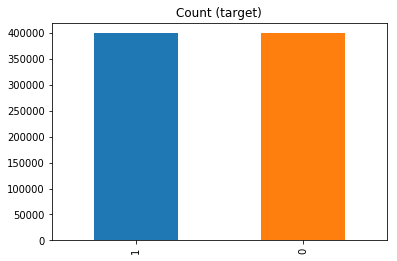

In [58]:
#extract the observations with class zero, equal to the number of obervations equal
df_class_1_under = df_class_1.sample(count_class_0)

#create a new dataframe with the same number of values for our two classes
df_resampled = pd.concat([df_class_1_under, df_class_0], axis=0, ignore_index=True)

print('Random under-sampling:')
print(df_resampled.on_time.value_counts())

df_resampled.on_time.value_counts().plot(kind='bar', title='Count (target)')

In [59]:
#shuffling the data to make it completely random, after resampling
from sklearn.utils import shuffle 
df_resampled = shuffle(df_resampled)

#resetting index
df_resampled = df_resampled.reset_index(drop=True)

In [60]:
df_resampled.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,Scheduled_HourOfDay,delay_second,delay_minute,delay_days,source,destination,dist,Vehicle_location2,VehicleToDestination,on_time
0,6/3/2017 21:38,1,B13,WYCKOFF AV/DE KALB AV,40.704323,-73.919373,SPRING CREEK GATEWAY MALL,40.652821,-73.876755,NYCT_4548,...,21,819,13.650000,0,"(40.704322999999995, -73.919373)","(40.652821, -73.876755)",6.759502,"(40.653308, -73.866276)",0.887908,0
1,6/4/2017 8:59,1,M15,E 126 ST/2 AV,40.803230,-73.932449,PIKE ST - DIVISION ST via 2 AV,40.710823,-73.991920,NYCT_5883,...,8,267,4.450000,0,"(40.80323, -73.932449)","(40.710823, -73.99192)",11.424657,"(40.764513, -73.961499)",6.492365,1
2,6/2/2017 13:16,1,B60,WASHINGTON PLZ/LANE 2,40.709518,-73.959496,CANARSIE WILLIAMS AV,40.650238,-73.891685,NYCT_7243,...,13,343,5.716667,0,"(40.709518, -73.959496)","(40.650238, -73.891685)",8.729246,"(40.64674, -73.90411)",1.120405,0
3,6/3/2017 11:07,0,B70,CROPSEY AV/BKLYN CAMPUS VA,40.609104,-74.023819,SUNSET PARK 39ST-1AV via 8 AV,40.656498,-74.012108,NYCT_783,...,11,76,1.266667,0,"(40.609103999999995, -74.02381899999999)","(40.656498, -74.012108)",5.355396,"(40.653513000000004, -74.00514799999999)",0.675540,1
4,6/3/2017 6:16,0,B2,E 16 ST/QUENTIN RD,40.607384,-73.957176,KINGS PLAZA,40.609428,-73.921753,NYCT_4593,...,6,86280,0.000000,-1,"(40.607384, -73.957176)","(40.609428, -73.92175300000001)",3.006470,"(40.612903, -73.926443)",0.553571,1


In [61]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 798404 entries, 0 to 798403
Data columns (total 32 columns):
RecordedAtTime               798404 non-null object
DirectionRef                 798404 non-null int64
PublishedLineName            798404 non-null object
OriginName                   798404 non-null object
OriginLat                    798404 non-null float64
OriginLong                   798404 non-null float64
DestinationName              798404 non-null object
DestinationLat               798404 non-null float64
DestinationLong              798404 non-null float64
VehicleRef                   798404 non-null object
VehicleLocation.Latitude     798404 non-null float64
VehicleLocation.Longitude    798404 non-null float64
NextStopPointName            798404 non-null object
ArrivalProximityText         798404 non-null object
DistanceFromStop             798404 non-null object
ExpectedArrivalTime          798404 non-null object
ScheduledArrivalTime         798404 non-null object


In [127]:
#getting the average of all columns by grouping the data by the output variable
df_resampled.groupby('on_time').mean()

,DirectionRef,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation.Latitude,VehicleLocation.Longitude,Scheduled_HourOfDay,delay_second,delay_minute,delay_days,dist,VehicleToDestination,dist_sqrt,VehicleToDestination_sqrt
on_time,,,,,,,,,,,,,,,
0,0.516941,40.735675,-73.932254,40.729343,-73.934197,40.731780,-73.932329,13.943547,4321.042390,28.899934,-0.030235,9.689733,4.034128,3.021455,1.718205
1,0.495626,40.726313,-73.929646,40.727947,-73.928952,40.726242,-73.928834,12.254160,32579.916554,1.393934,-0.376579,8.985628,4.990064,2.910618,2.012244


In [62]:
#creating two subsets of the dataframe to explore the data according to the different values of our binary output variable.
df_NotOntime = df_resampled[df_resampled['on_time'] == 0]
df_Ontime = df_resampled[df_resampled['on_time'] == 1]


In [63]:
#getting the total number of unique bus line names in the PublishedLineName column
df_resampled.PublishedLineName.describe()

count     798404
unique       305
top           B6
freq       14403
Name: PublishedLineName, dtype: object

In [64]:
#Using the subset of the data for the buses that did not make it on time, and getting the total number of unique bus line
#names in this subset of the data.
df_NotOntime.PublishedLineName.describe()

count     399202
unique       305
top          B41
freq        7546
Name: PublishedLineName, dtype: object

In [65]:
#Using the subset of the data for the buses that did make it on time, and getting the total number of unique bus line 
#names in this subset of the data
df_Ontime.PublishedLineName.describe()

count     399202
unique       236
top           B6
freq        8650
Name: PublishedLineName, dtype: object

There are 69 Bus lines that never made it on time to their destination.

In [66]:
notontime = df_NotOntime.PublishedLineName
ontime = df_Ontime.PublishedLineName

In [67]:
#identifying the PublishedLineName that were never on time.
intersect = np.intersect1d(notontime, ontime)
difference1 = np.setdiff1d(notontime, intersect)
#difference2 = np.setdiff1d(ontime, intersect)

In [140]:
#creating a new dataframe with the bus lines in PublishedLineName that were never on time.
df_LinesLate = df_resampled[df_resampled.PublishedLineName.isin(difference1)]
df_LinesLate.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,delay_minute,delay_days,source,destination,dist,Vehicle_location2,VehicleToDestination,on_time,dist_sqrt,VehicleToDestination_sqrt
1314,6/4/2017 13:18,1,Q35,HARDING AV/HOSMER AV,40.812946,-73.827042,BROOKLYN COLL FLATBUSH AV STA via FLATBUSH AV,40.696106,-73.990364,MTABC_3633,...,8.666667,0,"(40.812946000000004, -73.827042)","(40.696106, -73.990364)",18.935910,"(40.589457, -73.899928)",14.098829,0,4.351541,3.754841
1755,6/3/2017 18:08,0,B103,CENTRAL PARK S/6 AV,40.766315,-73.977493,LIMITED CANARSIE - WILLIAMS AVE via AVENUE H v...,40.838711,-73.860626,MTABC_515,...,22.200000,0,"(40.766315000000006, -73.97749300000001)","(40.838710999999996, -73.860626)",12.723688,"(40.63862, -73.95376800000001)",23.571563,0,3.567028,4.855055
3713,6/3/2017 18:07,0,Q53,CENTRAL PARK S/6 AV,40.766315,-73.977493,LIMITED WOODSIDE - 61 ST STA via CROSS BAY BL ...,40.647278,-73.779633,MTABC_3585,...,25.200000,0,"(40.766315000000006, -73.97749300000001)","(40.647278, -73.77963299999999)",21.314642,"(40.609446000000005, -73.818983)",5.360343,0,4.616778,2.315242
4495,6/3/2017 18:07,1,Q114,CENTRAL PARK S/6 AV,40.766315,-73.977493,LIMITED FAR ROCKAWAY SEAGIRT BL via BREWER BL ...,40.642979,-73.878334,MTABC_5403,...,24.200000,0,"(40.766315000000006, -73.97749300000001)","(40.642979, -73.878334)",16.056447,"(40.64634, -73.744635)",11.315141,0,4.007050,3.363799
4820,6/4/2017 17:49,1,QM4,ELTINGVILLE/TRANSIT CENTER,40.560760,-74.171089,MIDTOWN 57 ST via 6 AV,40.875988,-73.829735,MTABC_3225,...,46.000000,0,"(40.560759999999995, -74.171089)","(40.875988, -73.829735)",45.356713,"(40.737947, -73.936302)",17.772207,0,6.734739,4.215710


In [142]:
df_LinesLate.PublishedLineName.describe()

count     1451
unique      69
top        Q53
freq        69
Name: PublishedLineName, dtype: object

Text(0.5, 0, 'Latitude')

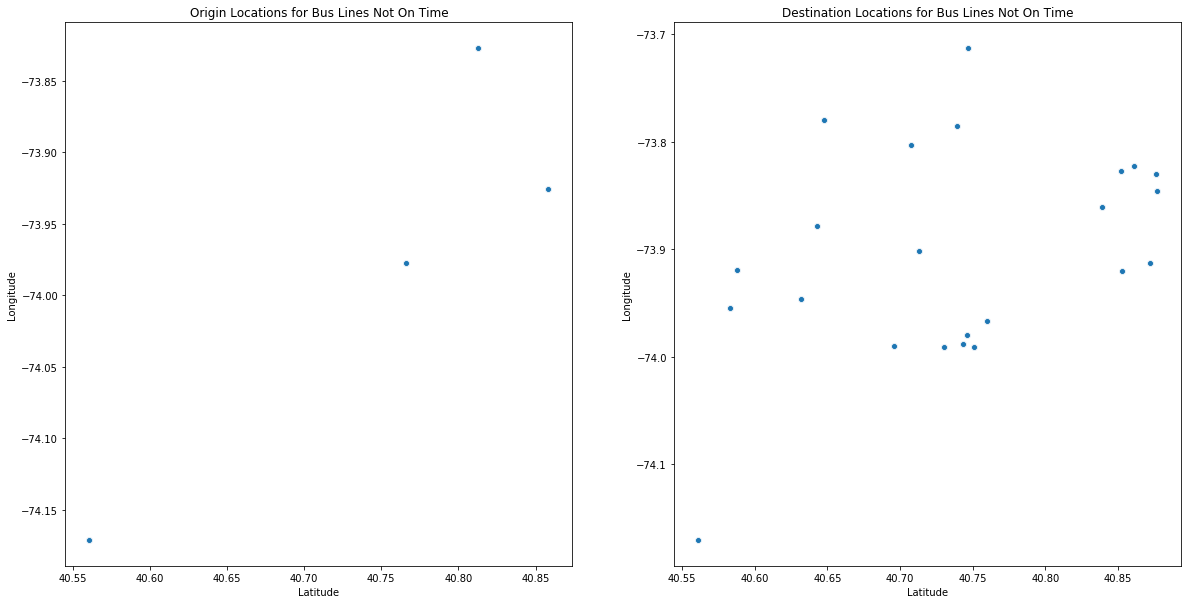

In [157]:
#making two scatter plots to show the Origin locations of buses on time, and not on time, using Origin latitude 
#and Origin longitude

#setting figure size
f = plt.figure(figsize=(20,10))

#making a plot figure that will have one row with two plots in each row
f.add_subplot(1, 2, 1)
sns.scatterplot(x=df_LinesLate.OriginLat, y=df_LinesLate.OriginLong)
plt.title("Origin Locations for Bus Lines Not On Time")
plt.ylabel('Longitude')
plt.xlabel('Latitude')

f.add_subplot(1, 2, 2)
sns.scatterplot(x=df_LinesLate.DestinationLat, y=df_LinesLate.DestinationLong)
plt.title('Destination Locations for Bus Lines Not On Time')
plt.ylabel('Longitude')
plt.xlabel('Latitude')


This is interesting.  The bus lines that were never on time always originated from four particular locations: 40.56 and -74.18 (staten island), 40.77 and -73.97 (upper east side of manhattan), 40.86 and -73.92 (Bronx, near Yankee stadium and the Bronx zoo) , and 40.81 and -73.82 (near the east river)

Text(0.5, 0, 'Latitude')

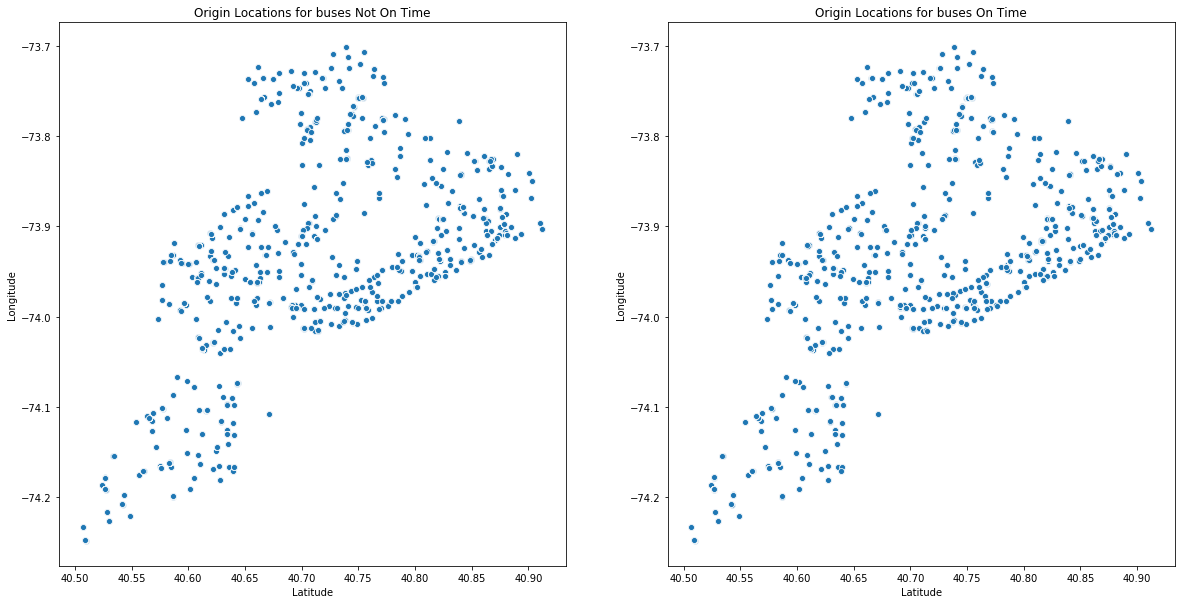

In [70]:
#making two scatter plots to show the Origin locations of buses on time, and not on time, using Origin latitude 
#and Origin longitude

#setting figure size
f = plt.figure(figsize=(20,10))

#making a plot figure that will have one row with two plots in each row
f.add_subplot(1, 2, 1)
sns.scatterplot(x=df_NotOntime.OriginLat, y=df_NotOntime.OriginLong)
plt.title("Origin Locations for buses Not On Time")
plt.ylabel('Longitude')
plt.xlabel('Latitude')

f.add_subplot(1, 2, 2)
sns.scatterplot(x=df_Ontime.OriginLat, y=df_Ontime.OriginLong)
plt.title('Origin Locations for buses On Time')
plt.ylabel('Longitude')
plt.xlabel('Latitude')


Text(0.5, 0, 'Latitude')

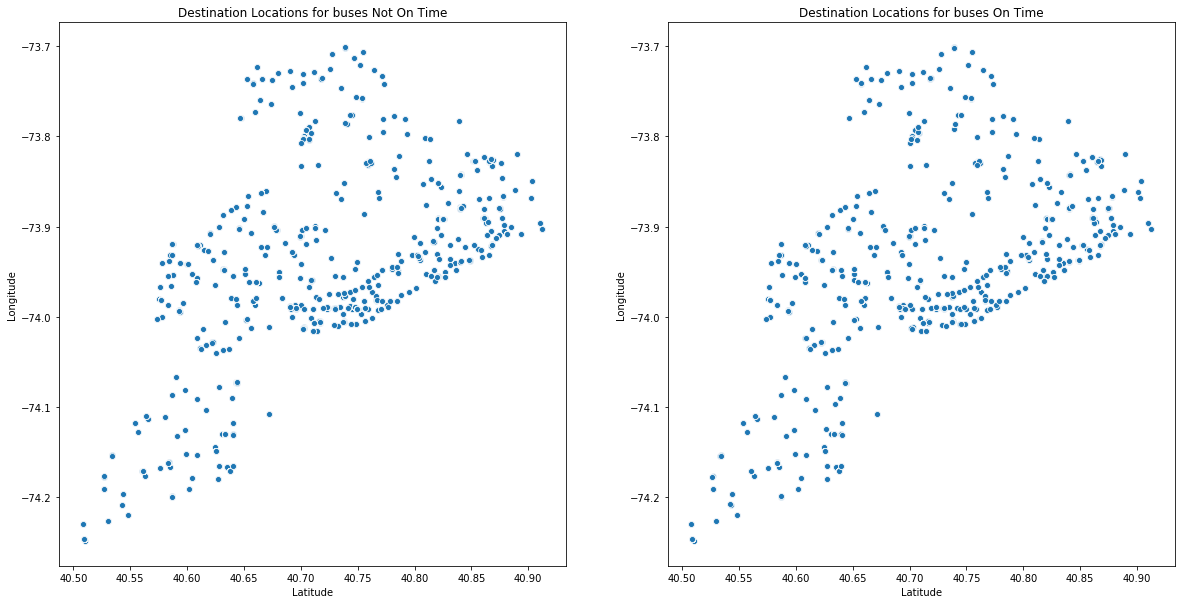

In [71]:
#making two scatter plots to show the Destination locations of buses on time, and not on time, using Destination latitude 
#and Destination longitude

#setting figure size
f = plt.figure(figsize=(20,10))

#making a plot figure that will have one row with two plots in each row
f.add_subplot(1, 2, 1)
sns.scatterplot(x=df_NotOntime.DestinationLat, y=df_NotOntime.DestinationLong)
plt.title("Destination Locations for buses Not On Time")
plt.ylabel('Longitude')
plt.xlabel('Latitude')

f.add_subplot(1, 2, 2)
sns.scatterplot(x=df_Ontime.DestinationLat, y=df_Ontime.DestinationLong)
plt.title('Destination Locations for buses On Time')
plt.ylabel('Longitude')
plt.xlabel('Latitude')

#hue=df_NotOntime.PublishedLineName[:15]

The two sets of scatterplot show the origin locations and destination locations using latitude and longitude for all buses, on time and those not on time, from the dataset.  As you can see, they are near identical for both scenarios, meaning that both scenarios have many common locations between them, and that location in and of itself is not the sole reason for a bus to be on time or not on time.

The box plots below show, show the scheduled hours of arrival for each bus stop.  On the left we have "Scheduled Hours of the day for buses Not On Time", and on the right we have "Scheduled Hours of the day for buses On Time".  As we can see, the median hour for the buses not on time is about 15, which is closer to the late afternoon rush hours.  But the median hour for the buses on time is closer to twelve, which is not close to either the morning or late afternoon rush hours.  

Also something important to note is that for those buses that are not on time, the first quartile (25% of the instances) is at about hour number eleven, which is significantly higher than the first quartile for those buses that were on time, which is at hour number eight.  This may suggest that for those buses that were not on time, the average hour is higher and closer to the later hours in the afternoon when there is probably more traffic on the road versus the average hour for those buses that were on time.

This insight may provide support for the idea that traffic is the differentiating factor on whether or not a bus is on time.

Text(0.5, 1.0, 'Scheduled Hours of the day for buses On Time')

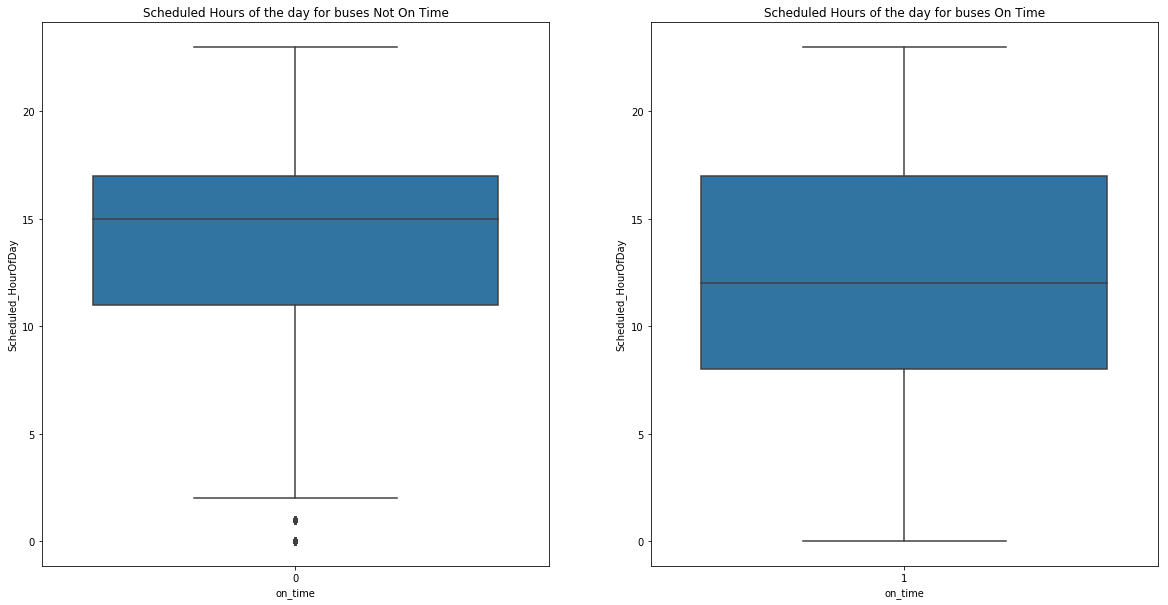

In [72]:
#Making a boxplot for the Scheduled_HourOfDay column for both subsets of our data, df_Ontime and df_NotOntime.

#setting figure size
f = plt.figure(figsize=(20,10))

#making a plot figure that will have one row with two plots in each row
f.add_subplot(1, 2, 1)
sns.boxplot(x=df_NotOntime.on_time, y=df_NotOntime.Scheduled_HourOfDay, data=df_NotOntime)
plt.title("Scheduled Hours of the day for buses Not On Time")


f.add_subplot(1, 2, 2)
sns.boxplot(x=df_Ontime.on_time, y=df_Ontime.Scheduled_HourOfDay, data=df_Ontime)
plt.title("Scheduled Hours of the day for buses On Time")


<Figure size 2880x1440 with 0 Axes>

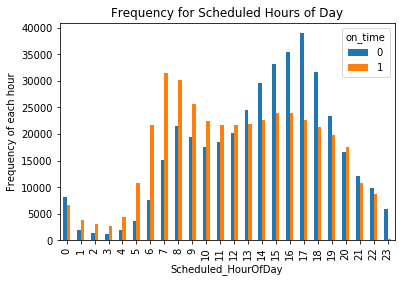

In [158]:
plt.figure(figsize=(40,20))
pd.crosstab(df_resampled.Scheduled_HourOfDay,df_resampled.on_time).plot(kind='bar')
plt.title('Frequency for Scheduled Hours of Day')
plt.xlabel('Scheduled_HourOfDay')
plt.ylabel('Frequency of each hour')
plt.show()

<Figure size 2880x1440 with 0 Axes>

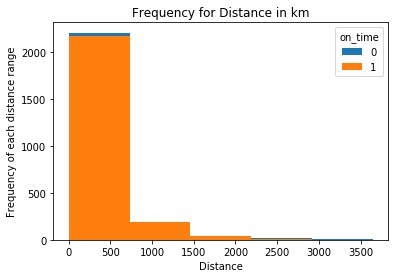

In [154]:
plt.figure(figsize=(40,20))
pd.crosstab(df_resampled.dist,df_resampled.on_time).plot(kind='hist', bins=5)
plt.title('Frequency for Distance in km')
plt.xlabel('Distance')
plt.ylabel('Frequency of each distance range')
plt.show()

In [73]:
#getting the average of Scheduled_HourOfDay for buses not on time
print(np.mean(df_NotOntime['Scheduled_HourOfDay']))

13.943547377017149


In [74]:
#getting the average of Scheduled_HourOfDay for buses on time.
print(np.mean(df_Ontime['Scheduled_HourOfDay']))

12.254159548298857


As expected, the average of the scheduled arrival hour for the buses not on time is higher, at 13.94, versus the average of the scheduled arrival hour for the buses that were on time, which is 12.26

In [75]:
df_resampled['dist_sqrt'] = np.sqrt(df_resampled['dist'])
df_resampled['VehicleToDestination_sqrt'] = np.sqrt(df_resampled['VehicleToDestination'])


Performed square root transformation to the "dist" and "VehicleToDestination" features

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, "Distribution of 'dist_sqrt'")

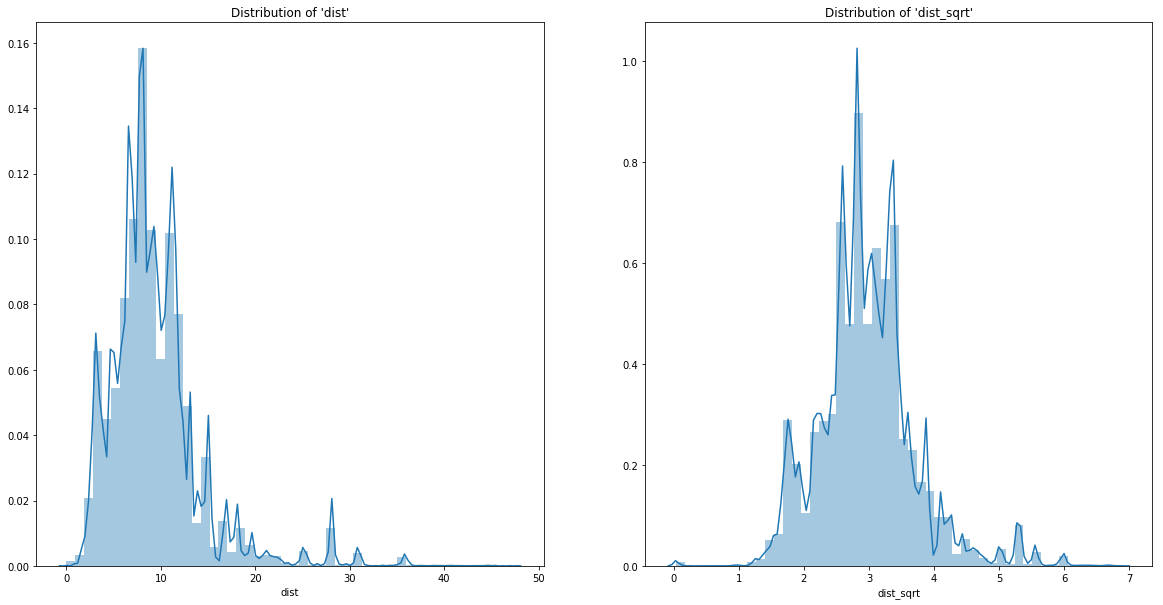

In [76]:
#Making Two historgrams for the dist and dist_logged columns from the main dataset

#setting figure size
f = plt.figure(figsize=(20,10))

#making a plot figure that will have one row with two plots in each row
f.add_subplot(1, 2, 1)
sns.distplot(df_resampled['dist'])
plt.title("Distribution of 'dist'")


f.add_subplot(1, 2, 2)
sns.distplot(df_resampled['dist_sqrt'])
plt.title("Distribution of 'dist_sqrt'")


Applying the square root transformation to "dist" created gave the feature a normal distribution.

Text(0.5, 1.0, "Distribution of 'VehicleToDestination_sqrt'")

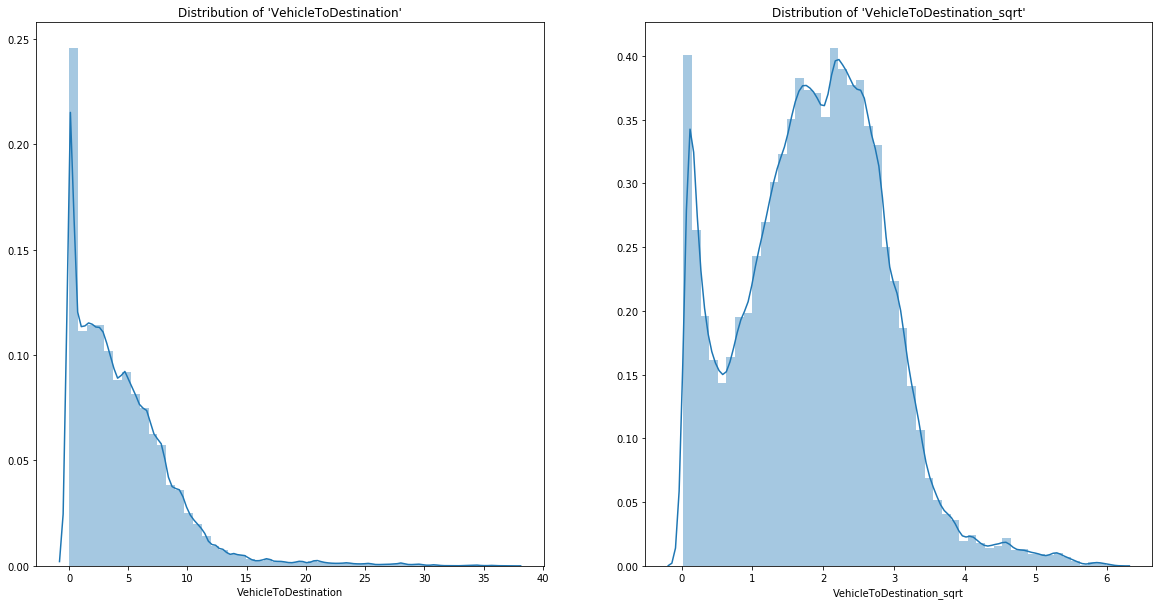

In [77]:
#Making Two historgrams for the VehicleToDestination and VehicleToDestination_logged columns from the main dataset

#setting figure size
f = plt.figure(figsize=(20,10))

#making a plot figure that will have one row with two plots in each row
f.add_subplot(1, 2, 1)
sns.distplot(df_resampled['VehicleToDestination'])
plt.title("Distribution of 'VehicleToDestination'")


f.add_subplot(1, 2, 2)
sns.distplot(df_resampled['VehicleToDestination_sqrt'])
plt.title("Distribution of 'VehicleToDestination_sqrt'")


But applying the square root transformation didn't create a normal distribution for "VehicleToDestination".

Text(0.5, 0, 'dist_sqrt')

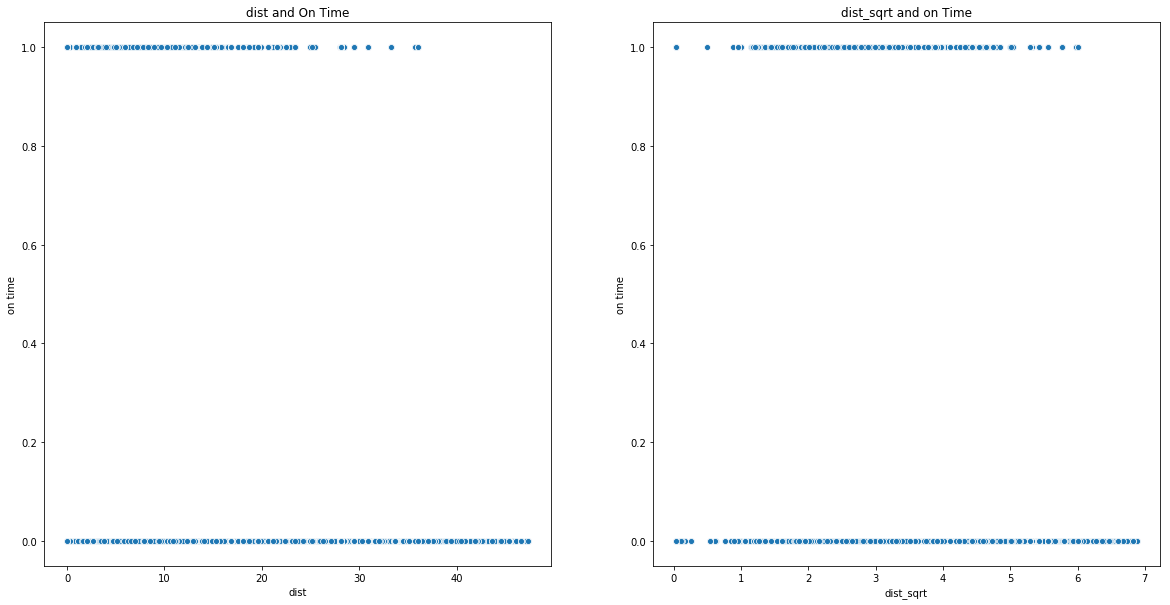

In [79]:
#making two scatter plots to show the Destination locations of buses on time, and not on time, using Destination latitude 
#and Destination longitude

#setting figure size
f = plt.figure(figsize=(20,10))

#making a plot figure that will have one row with two plots in each row
f.add_subplot(1, 2, 1)
sns.scatterplot(x=df_resampled['dist'], y=df_resampled['on_time'])
plt.title("dist and On Time")
plt.ylabel('on time')
plt.xlabel('dist')

f.add_subplot(1, 2, 2)
sns.scatterplot(x=df_resampled['dist_sqrt'], y=df_resampled['on_time'])
plt.title('dist_sqrt and on Time')
plt.ylabel('on time')
plt.xlabel('dist_sqrt')

#hue=df_NotOntime.PublishedLineName[:15]

In [80]:
df_resampled.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'Unnamed: 17', 'expected_date',
       'Scheduled_datetime', 'Expected_datetime', 'delay',
       'Scheduled_HourOfDay', 'delay_second', 'delay_minute', 'delay_days',
       'source', 'destination', 'dist', 'Vehicle_location2',
       'VehicleToDestination', 'on_time', 'dist_sqrt',
       'VehicleToDestination_sqrt'],
      dtype='object')

In [81]:
#dropping some columns and creating the dataframe with the independent variables
df_X = df_resampled.drop(['RecordedAtTime', 'ArrivalProximityText', 'Unnamed: 17', 'PublishedLineName', 'VehicleRef', 
                 'NextStopPointName', 'ExpectedArrivalTime', 'ScheduledArrivalTime', 'on_time', 'OriginName', 
                 'DestinationName','source', 'destination', 'Vehicle_location2', 'DistanceFromStop', 'Scheduled_datetime', 
                 'Expected_datetime', 'delay', 'delay_second', 'delay_minute', 'delay_days', 'source', 
                 'destination', 'expected_date', 'dist_sqrt', 'VehicleToDestination_sqrt'], 1)

#creating dataframe of the independent (predictor) values
#XD_df = pd.get_dummies(X, columns=['OriginName', 'DestinationName'])


Y = df_resampled['on_time']



In [82]:
#examining the dataframe with the predictor variables
df_X.head()

,DirectionRef,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation.Latitude,VehicleLocation.Longitude,Scheduled_HourOfDay,dist,VehicleToDestination
0,1,40.704323,-73.919373,40.652821,-73.876755,40.653308,-73.866276,21,6.759502,0.887908
1,1,40.803230,-73.932449,40.710823,-73.991920,40.764513,-73.961499,8,11.424657,6.492365
2,1,40.709518,-73.959496,40.650238,-73.891685,40.646740,-73.904110,13,8.729246,1.120405
3,0,40.609104,-74.023819,40.656498,-74.012108,40.653513,-74.005148,11,5.355396,0.675540
4,0,40.607384,-73.957176,40.609428,-73.921753,40.612903,-73.926443,6,3.006470,0.553571


In [84]:
#checking shape of X
df_X.shape

(798404, 10)

In [85]:
#checking which column has NaN value
df_X.isnull().sum().sum()

0

In [86]:
#checking the shape of outcome variable Y.
Y.shape

(798404,)

In [87]:
#creating initial train_test_split, before PCA
train_X, test_X, train_Y, test_Y = train_test_split(df_X, Y, test_size=.25)
print(test_X.shape)
print(test_Y.shape)

#checking for any NaN values in our data.
#print(np.isnan(train_Y).any())
#print(np.isnan(train_X).any().sum())
#print(np.isnan(test_Y).any())
#print(np.isnan(test_X).any().sum())

(199601, 10)
(199601,)


In [88]:
#creating a smaller dataset with full features

df_X_FullDataSmall = df_X.iloc[:150000, :]
print(df_X_FullDataSmall.shape)

#getting a smaller sample set for output variable Y 
Y_FullDataSmall = Y[:150000]
print(Y_FullDataSmall.shape)

(150000, 10)
(150000,)


In [89]:
#creating a second train_test_split, using small dataset with full features
train_X_FullDataSmall, test_X_FullDataSmall, train_Y_FullDataSmall, test_Y_FullDataSmall = train_test_split(df_X_FullDataSmall, Y_FullDataSmall, test_size=.25)
print(test_X_FullDataSmall.shape)
print(test_Y_FullDataSmall.shape)

#checking for any NaN values in our data.
#print(np.isnan(train_Y).any())
#print(np.isnan(train_X).any().sum())
#print(np.isnan(test_Y).any())
#print(np.isnan(test_X).any().sum())

(37500, 10)
(37500,)


In [94]:
# Create the first model by Initializing and training the decision tree
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=10,
    max_depth=16,
    min_samples_split=10
)

#set start time
start_time_tree = datetime.datetime.now()

#train our tree
decision_tree.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_dtree = decision_tree.predict(test_X)

#get accuracy score from our model
print('Accuracy score for decision tree Model: ' + str(metrics.accuracy_score(test_Y, y_pred_dtree)))

#calculate end time
end_time_tree = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_tree - start_time_tree))
print()

#get accuracy score of decision tree
tree_score = cross_val_score(decision_tree, df_X, Y, cv=10, scoring='accuracy')
print(tree_score)
print('Average cross validated score from our decision tree model is: ' + str(np.mean(tree_score)))

Accuracy score for decision tree Model: 0.6671860361421035

Duration: 0:00:05.523208

[0.66996067 0.67014854 0.66723447 0.66703407 0.66782315 0.66847445
 0.67044088 0.6694514  0.66684619 0.66822395]
Average cross validated score from our decision tree model is: 0.6685637772815237


AUC Score: 0.722


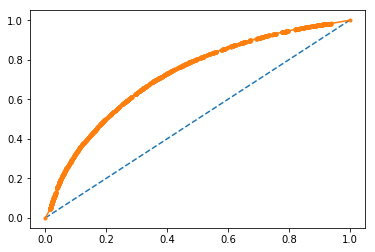


Confusion Matrix: 
 [[66166 33095]
 [33335 67005]]

              precision    recall  f1-score   support

     Class_0       0.66      0.67      0.67     99261
     Class_1       0.67      0.67      0.67    100340

   micro avg       0.67      0.67      0.67    199601
   macro avg       0.67      0.67      0.67    199601
weighted avg       0.67      0.67      0.67    199601



In [98]:
#Get AUC and create ROC
# predict probabilities
probs_dtree = decision_tree.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_dtree = probs_dtree[:, 1]
# calculate AUC
dtree_auc = roc_auc_score(test_Y, probs_dtree)
print('AUC Score: %.3f' % dtree_auc)
# calculate roc curve
fpr_dtree, tpr_dtree, thresholds_dtree = roc_curve(test_Y, probs_dtree)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_dtree, tpr_dtree, marker='.')
# show the plot
plt.show()
print()

# create confusion matrix for random forest and PCA
print("Confusion Matrix: \n", confusion_matrix(test_Y, y_pred_dtree))
print()

# perform classification report of the logistic regression model
class_names = ['Class_0', 'Class_1']
dtree_report = classification_report(test_Y, y_pred_dtree, target_names=class_names)
print(dtree_report)

In [102]:
#dropping some columns and creating the dataframe for the independent variables, including 'dist_sqrt' and 'VehicleToDestination_sqrt'
df_X_linear = df_resampled.drop(['RecordedAtTime', 'ArrivalProximityText', 'Unnamed: 17', 'PublishedLineName', 'VehicleRef', 
                 'NextStopPointName', 'ExpectedArrivalTime', 'ScheduledArrivalTime', 'on_time', 'OriginName', 
                 'DestinationName','source', 'destination', 'Vehicle_location2', 'DistanceFromStop', 'Scheduled_datetime', 
                 'Expected_datetime', 'delay', 'delay_second', 'delay_minute', 'delay_days', 'source', 
                 'destination', 'expected_date', 'dist', 'VehicleToDestination'], 1)

In [103]:
#creating initial train_test_split, before PCA
train_X_linear, test_X_linear, train_Y_linear, test_Y_linear = train_test_split(df_X_linear, Y, test_size=.25)
print(test_X_linear.shape)
print(test_Y_linear.shape)

#checking for any NaN values in our data.
#print(np.isnan(train_Y).any())
#print(np.isnan(train_X).any().sum())
#print(np.isnan(test_Y).any())
#print(np.isnan(test_X).any().sum())

(199601, 10)
(199601,)


# Logistic Regression with linear relationship

In [107]:
#initialize and train our model with special features added to create linear relationship with output variable.
LogReg_linear = LogisticRegression(C=1e9)

#set start time
start_time4 = datetime.datetime.now()

#fit and train the model
LogReg_linear.fit(train_X_linear, train_Y_linear)

# Classify, storing the result in a new variable.
y_pred_LogReg_linear = LogReg_linear.predict(test_X_linear)

#get accuracy score from our model
print('Accuracy score for Logistic regression Model: ' + str(metrics.accuracy_score(test_Y_linear, y_pred_LogReg_linear)))

#calculate end time
end_time4 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time4 - start_time4))
print()

#get average accuracy score using cross validation
LogReg_cvs_linear = cross_val_score(LogReg_linear, df_X_linear, Y, cv=10, scoring='accuracy')
print(LogReg_cvs_linear)

print('Average cross validated score from our log regression model is: ' + str(np.mean(LogReg_cvs_linear)))

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score for Logistic regression Model: 0.6184387853768267

Duration: 0:00:21.329529



C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

[0.61838381 0.61929811 0.61887525 0.62131764 0.61663327 0.61737224
 0.619752   0.61817385 0.6176478  0.61763527]
Average cross validated score from our log regression model is: 0.6185089236424803


AUC Score: 0.666


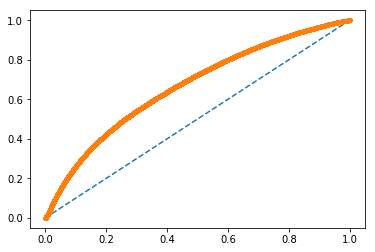


Confusion Matrix: 
 [[59503 40077]
 [36083 63938]]

              precision    recall  f1-score   support

     Class_0       0.62      0.60      0.61     99580
     Class_1       0.61      0.64      0.63    100021

   micro avg       0.62      0.62      0.62    199601
   macro avg       0.62      0.62      0.62    199601
weighted avg       0.62      0.62      0.62    199601



In [126]:
#Get AUC and create ROC
# predict probabilities
probs_LogReg_linear = LogReg_linear.predict_proba(test_X_linear)
# keep probabilities for the positive outcome only
probs_LogReg_linear = probs_LogReg_linear[:, 1]
# calculate AUC
LogReg_auc = roc_auc_score(test_Y_linear, probs_LogReg_linear)
print('AUC Score: %.3f' % LogReg_auc)
# calculate roc curve
fpr_LogReg, tpr_LogReg, thresholds_LogReg = roc_curve(test_Y_linear, probs_LogReg_linear)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_LogReg, tpr_LogReg, marker='.')
# show the plot
plt.show()
print()

# create confusion matrix for random forest and PCA
print("Confusion Matrix: \n", confusion_matrix(test_Y_linear, y_pred_LogReg_linear))
print()

# perform classification report of the logistic regression model
class_names = ['Class_0', 'Class_1']
LogReg_linear_report = classification_report(test_Y_linear, y_pred_LogReg_linear, target_names=class_names)
print(LogReg_linear_report)

# Logistic Regression

In [91]:
#initialize and train our model full features
LogReg = LogisticRegression(C=1e9)

#set start time
start_time4 = datetime.datetime.now()

#fit and train the model
LogReg.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_LogReg = LogReg.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Logistic regression Model: ' + str(metrics.accuracy_score(test_Y, y_pred_LogReg)))

#calculate end time
end_time4 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time4 - start_time4))
print()

#get average accuracy score using cross validation
LogReg_cvs = cross_val_score(LogReg, df_X, Y, cv=10, scoring='accuracy')
print(LogReg_cvs)

print('Average cross validated score from our log regression model is: ' + str(np.mean(LogReg_cvs)))

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score for Logistic regression Model: 0.6134187704470419

Duration: 0:00:16.776587



C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

[0.61242203 0.61336139 0.6129509  0.61421593 0.61038327 0.61012024
 0.61427856 0.61341433 0.61288828 0.61176102]
Average cross validated score from our log regression model is: 0.6125795947309062


AUC Score: 0.666


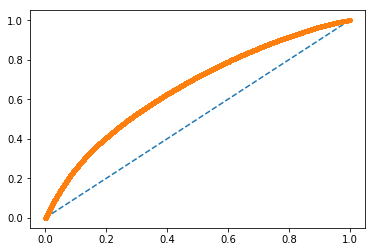


Confusion Matrix: 
 [[60112 39149]
 [38013 62327]]

              precision    recall  f1-score   support

     Class_0       0.61      0.61      0.61     99261
     Class_1       0.61      0.62      0.62    100340

   micro avg       0.61      0.61      0.61    199601
   macro avg       0.61      0.61      0.61    199601
weighted avg       0.61      0.61      0.61    199601



In [167]:
#Get AUC and create ROC
# predict probabilities
probs_LogReg = LogReg.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_LogReg = probs_LogReg[:, 1]
# calculate AUC
LogReg_normal_auc = roc_auc_score(test_Y, probs_LogReg)
print('AUC Score: %.3f' % LogReg_auc)
# calculate roc curve
fpr_LogReg_normal, tpr_LogReg_normal, thresholds_LogReg_normal = roc_curve(test_Y, probs_LogReg)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_LogReg_normal, tpr_LogReg_normal, marker='.')
# show the plot
plt.show()
print()

# create confusion matrix for random forest and PCA
print("Confusion Matrix: \n", confusion_matrix(test_Y, y_pred_LogReg))
print()

# perform classification report of the logistic regression model
class_names = ['Class_0', 'Class_1']
LogReg_report_normal = classification_report(test_Y, y_pred_LogReg, target_names=class_names)
print(LogReg_report_normal)

The decision tree had a higher score of 65%, than the logistic regression score of 61%.  After examining the data and specifically the types of features in the data, I would expect the tree based models to give a better accuracy score than models based on a linear relationship.

Consider the features using latitude and longitude to define location in our model.  The Latitude and longitude are horizontal and vertical lines numbered in a consecutive order of a grid-like system to identify different locations on Earth, and for this project specifically New york City.  

The decision tree algorithm analyzes the data set to create a set of rules or questions, which ultimately help to predict a class.  Each node in the tree, except final leafs, use these questions or rules to create a split at each node of the tree and subset the data according to the rule of question asked, with the hope of making each subsequent node in the tree have less impurity.  These questions are than layered one upon the other, with the goal of information gain as we move through these layers. The more information we gain, the more chances we have of getting to the right classification.

So in this dataset, the tree algorithm would decide which feature-value combination splits the data best.  It could use the values in the latitude or longitude features.  These features have the nature of a categorical variable; For example, as the first question at the root node, the model could ask for all the samples in the data with latitude greater than 77 degrees. This would subset the data and group all the samples greater than 77 with each other in the hope of the model gaining more information and leading to the proper classification.  Also, due to the nature of how latitude and longitude work, this also has the affect of grouping the different samples in the data according to location.  For example, all the samples greater than 77 degrees are in the upper part of the city, and all the samples below 77 degrees are at the bottom part of the city.

The "dist" and "VehicleToDist" would be used by the model in a similar way.  Also note that none of these features in our dataset has a linear relationship between the it and the output variable.

"I'll try to show the relationship between the independent variables and output variable here."



# PCA

In [95]:
# Normalize the data so that all variables have a mean of 0 and standard deviation
# o

X_scaled = StandardScaler().fit_transform(df_X)

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [96]:
#Apply PCA

pca = PCA(.95)
df_X_pca = pca.fit_transform(X_scaled)

comp_no = pca.n_components_
comp_var_ratio = pca.explained_variance_ratio_

print(comp_no)
print(comp_var_ratio)
#print(p_components)

7
[0.3948456  0.14986169 0.1328765  0.12983078 0.09972686 0.04257859
 0.02225918]


In [97]:
#pca data to dataframe
pca_df = pd.DataFrame(data=df_X_pca)
print(pca_df.head())
print(pca_df.shape)

          0         1         2         3         4         5         6
0 -0.039007 -1.520248  0.890772 -0.820155 -1.523077  0.132127  0.634467
1  0.209175  1.070873  1.064033 -0.203764  1.125023  0.014610  0.195718
2  0.497068 -1.179438  0.678382 -0.715983  0.022657  0.394936  0.842703
3  1.841608 -0.951024 -1.605300 -1.083741  0.269566 -0.128593 -0.251316
4  1.138786 -2.388164 -1.289019 -0.725915  1.174620 -0.423969  0.106470
(798404, 7)


In [112]:
#subset dataframe X to include only the first 600,000 rows.
df_X_SmallSet = pca_df.iloc[:200000, :]
print(df_X_SmallSet.shape)

#getting a smaller sample set for output variable Y 
Y_SmallSet = Y[:200000]
print(Y_SmallSet.shape)

(200000, 7)
(200000,)


In [113]:
#checking the values in Y
set(Y_SmallSet)

{0, 1}

In [114]:
#creating a train test split based on PCA and full data set.
train_X_PCA, test_X_PCA, train_Y_PCA, test_Y_PCA = train_test_split(pca_df, Y, test_size=.25)
print(test_X_PCA.shape)
print(test_Y_PCA.shape)

(199601, 7)
(199601,)


In [115]:
#creating a second train test split based on PCA and small data set.
train_X_SmallPCA, test_X_SmallPCA, train_Y_SmallPCA, test_Y_SmallPCA = train_test_split(df_X_SmallSet, Y_SmallSet, test_size=.25)
print(test_X_SmallPCA.shape)
print(test_Y_SmallPCA.shape)

(50000, 7)
(50000,)


# Random Forest with Full Features

In [321]:
# perform grid search to find the optimal parameters for our random forest model, with full features
rforest_fulldata = ensemble.RandomForestClassifier()
forest_param_grid = {'n_estimators':[60], 'max_depth':[6,8,10], 'min_samples_split':[8,10], 
                     'max_features':[2,4,6,8], 'criterion':['entropy', 'gini']}
rforest_grid_FullData = GridSearchCV(rforest_fulldata, forest_param_grid, cv=10, verbose=3)
rforest_grid_FullData.fit(train_X_FullDataSmall, train_Y_FullDataSmall)


Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60, score=0.6496311438983201, total=   3.3s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60, score=0.6404764020975914, total=   3.2s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s


[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60, score=0.6433205937250023, total=   3.3s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60, score=0.6484756910496845, total=   3.3s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60, score=0.6483555555555556, total=   3.4s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60, score=0.6366222222222222, total=   3.3s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=8, n_estimators=60, score=0.64645746

[CV]  criterion=entropy, max_depth=6, max_features=4, min_samples_split=10, n_estimators=60, score=0.63916792603787, total=   6.1s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=8, n_estimators=60, score=0.64207625988801, total=   8.8s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=8, n_estimators=60, score=0.639676473202382, total=   8.9s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=8, n_estimators=60, score=0.6394987112256688, total=   8.7s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=8, n_estimators=60, score=0.645542618433

[CV]  criterion=entropy, max_depth=6, max_features=8, min_samples_split=10, n_estimators=60, score=0.643968352742466, total=  11.7s
[CV] criterion=entropy, max_depth=6, max_features=8, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=8, min_samples_split=10, n_estimators=60, score=0.6408569650635612, total=  11.8s
[CV] criterion=entropy, max_depth=6, max_features=8, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=8, min_samples_split=10, n_estimators=60, score=0.6328562538892346, total=  11.8s
[CV] criterion=entropy, max_depth=6, max_features=8, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=6, max_features=8, min_samples_split=10, n_estimators=60, score=0.6389012356653925, total=  11.6s
[CV] criterion=entropy, max_depth=8, max_features=2, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=8, max_features=2, min_samples_split=8, n_estimators=60, score=0.66

[CV]  criterion=entropy, max_depth=8, max_features=4, min_samples_split=10, n_estimators=60, score=0.6553195271531419, total=   7.9s
[CV] criterion=entropy, max_depth=8, max_features=4, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=8, max_features=4, min_samples_split=10, n_estimators=60, score=0.6522666666666667, total=   8.0s
[CV] criterion=entropy, max_depth=8, max_features=4, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=8, max_features=4, min_samples_split=10, n_estimators=60, score=0.6546666666666666, total=   7.9s
[CV] criterion=entropy, max_depth=8, max_features=4, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=8, max_features=4, min_samples_split=10, n_estimators=60, score=0.6528580318250511, total=   7.7s
[CV] criterion=entropy, max_depth=8, max_features=4, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=8, max_features=4, min_samples_split=10, n_estimators=60, score=0

[CV]  criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=60, score=0.6541640743045063, total=  15.3s
[CV] criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=60, score=0.6466091902941961, total=  15.5s
[CV] criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=60, score=0.6501644298284597, total=  15.4s
[CV] criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=60, score=0.6505199537818861, total=  15.4s
[CV] criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=8, max_features=8, min_samples_split=10, n_estimators=60, score=0

[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_split=8, n_estimators=60, score=0.6587252200195572, total=   9.8s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_split=8, n_estimators=60, score=0.6535692061516579, total=   9.6s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_split=8, n_estimators=60, score=0.6541914836874388, total=   9.7s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_split=10, n_estimators=60, score=0.663763221047018, total=   9.7s
[CV] criterion=entropy, max_depth=10, max_features=4, min_samples_split=10, n_estimators=60 
[CV]  criterion=entropy, max_depth=10, max_features=4, min_samples_split=10, n_estimators=60, scor

[CV]  criterion=entropy, max_depth=10, max_features=8, min_samples_split=8, n_estimators=60, score=0.6648888888888889, total=  18.8s
[CV] criterion=entropy, max_depth=10, max_features=8, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=10, max_features=8, min_samples_split=8, n_estimators=60, score=0.6612444444444444, total=  18.9s
[CV] criterion=entropy, max_depth=10, max_features=8, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=10, max_features=8, min_samples_split=8, n_estimators=60, score=0.6573917681571695, total=  18.8s
[CV] criterion=entropy, max_depth=10, max_features=8, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=10, max_features=8, min_samples_split=8, n_estimators=60, score=0.6575695617388212, total=  18.9s
[CV] criterion=entropy, max_depth=10, max_features=8, min_samples_split=8, n_estimators=60 
[CV]  criterion=entropy, max_depth=10, max_features=8, min_samples_split=8, n_estimators=60, score=0

[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=8, n_estimators=60, score=0.6434094747133589, total=   4.8s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=8, n_estimators=60, score=0.6439427606434983, total=   4.8s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=8, n_estimators=60, score=0.6448888888888888, total=   4.9s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=8, n_estimators=60, score=0.6438222222222222, total=   4.7s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=8, n_estimators=60, score=0.6426349008800782, total=   4.8s
[CV

[CV]  criterion=gini, max_depth=6, max_features=8, min_samples_split=8, n_estimators=60, score=0.6443871655852813, total=   9.1s
[CV] criterion=gini, max_depth=6, max_features=8, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=6, max_features=8, min_samples_split=8, n_estimators=60, score=0.6371878055283975, total=   9.1s
[CV] criterion=gini, max_depth=6, max_features=8, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=6, max_features=8, min_samples_split=8, n_estimators=60, score=0.6417207359345836, total=   9.0s
[CV] criterion=gini, max_depth=6, max_features=8, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=6, max_features=8, min_samples_split=8, n_estimators=60, score=0.6427873077948627, total=   9.1s
[CV] criterion=gini, max_depth=6, max_features=8, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=6, max_features=8, min_samples_split=8, n_estimators=60, score=0.644, total=   9.1s
[CV] criterion=g

[CV]  criterion=gini, max_depth=8, max_features=2, min_samples_split=10, n_estimators=60, score=0.6469908436305449, total=   3.3s
[CV] criterion=gini, max_depth=8, max_features=2, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=8, max_features=2, min_samples_split=10, n_estimators=60, score=0.6485909858654103, total=   3.5s
[CV] criterion=gini, max_depth=8, max_features=4, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=8, max_features=4, min_samples_split=8, n_estimators=60, score=0.6545195982579326, total=   6.0s
[CV] criterion=gini, max_depth=8, max_features=4, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=8, max_features=4, min_samples_split=8, n_estimators=60, score=0.6474091191894054, total=   6.0s
[CV] criterion=gini, max_depth=8, max_features=4, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=8, max_features=4, min_samples_split=8, n_estimators=60, score=0.6515865256421651, total=   6.0s


[CV]  criterion=gini, max_depth=8, max_features=6, min_samples_split=10, n_estimators=60, score=0.6545470708507423, total=   8.9s
[CV] criterion=gini, max_depth=8, max_features=6, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=8, max_features=6, min_samples_split=10, n_estimators=60, score=0.6519690639167927, total=   8.9s
[CV] criterion=gini, max_depth=8, max_features=6, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=8, max_features=6, min_samples_split=10, n_estimators=60, score=0.6465463596764157, total=   8.8s
[CV] criterion=gini, max_depth=8, max_features=6, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=8, max_features=6, min_samples_split=10, n_estimators=60, score=0.6506356120544048, total=   8.9s
[CV] criterion=gini, max_depth=8, max_features=8, min_samples_split=8, n_estimators=60 
[CV]  criterion=gini, max_depth=8, max_features=8, min_samples_split=8, n_estimators=60, score=0.6554972891298552, total=  11

[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_split=10, n_estimators=60, score=0.6631111111111111, total=   4.0s
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_split=10, n_estimators=60, score=0.6576888888888889, total=   4.2s
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_split=10, n_estimators=60, score=0.6627255756067206, total=   4.0s
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_split=10, n_estimators=60, score=0.6581918392746022, total=   4.0s
[CV] criterion=gini, max_depth=10, max_features=2, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=10, max_features=2, min_samples_split=10, n_estimators=60, score=0.6556138323406525,

[CV]  criterion=gini, max_depth=10, max_features=6, min_samples_split=10, n_estimators=60, score=0.6605635054661808, total=  10.7s
[CV] criterion=gini, max_depth=10, max_features=6, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=10, max_features=6, min_samples_split=10, n_estimators=60, score=0.6641187450004444, total=  10.9s
[CV] criterion=gini, max_depth=10, max_features=6, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=10, max_features=6, min_samples_split=10, n_estimators=60, score=0.6629333333333334, total=  10.8s
[CV] criterion=gini, max_depth=10, max_features=6, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=10, max_features=6, min_samples_split=10, n_estimators=60, score=0.6618666666666667, total=  10.7s
[CV] criterion=gini, max_depth=10, max_features=6, min_samples_split=10, n_estimators=60 
[CV]  criterion=gini, max_depth=10, max_features=6, min_samples_split=10, n_estimators=60, score=0.6626366788158947,

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 74.2min finished


NameError: name 'rforest_grid_FullDataSmall' is not defined

In [323]:
print('Best parameters for random forest with full features:', rforest_grid_FullData.best_params_)
print('Best score for random forest with full features:', rforest_grid_FullData.best_score_)

Best parameters for random forest with full features: {'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'min_samples_split': 10, 'n_estimators': 60}
Best score for random forest with full features: 0.6610844444444445


In [326]:
#initialize and train random forest model with full features
rand_forest = ensemble.RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=16, max_features=6,
                                              min_samples_split=10)

#set start time
start_time_rforest = datetime.datetime.now()

rand_forest.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_rforest = rand_forest.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Random Forest Model: ' + str(metrics.accuracy_score(test_Y, y_pred_rforest)))

#calculate end time
end_time_rforest = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_rforest - start_time_rforest))
print()

#get average accuracy score of our random forest through cross validation
rforest_cvs = cross_val_score(rand_forest, df_X, Y, cv=10, scoring='accuracy')
print(rforest_cvs)
print('Average cross validated score from our Random Forest Model is: ' + str(np.mean(rforest_cvs)))

Accuracy score for Random Forest Model: 0.6812490919384171

Duration: 0:03:30.284876

[0.6843015  0.68445179 0.68255261 0.68207665 0.68197645 0.68434369
 0.68439379 0.68311623 0.68106212 0.68747495]
Average cross validated score from our Random Forest Model is: 0.6835749780729266


AUC Score: 0.748


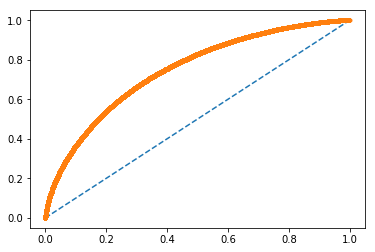


Confusion Matrix: 
 [[68309 31850]
 [31773 67669]]

              precision    recall  f1-score   support

     Class_0       0.68      0.68      0.68    100159
     Class_1       0.68      0.68      0.68     99442

   micro avg       0.68      0.68      0.68    199601
   macro avg       0.68      0.68      0.68    199601
weighted avg       0.68      0.68      0.68    199601



In [327]:
#Get AUC and create ROC for Random Forest
# predict probabilities
probs_rforest = rand_forest.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_rforest = probs_rforest[:, 1]
# calculate AUC
rforest_auc = roc_auc_score(test_Y, probs_rforest)
print('AUC Score: %.3f' % rforest_auc)
# calculate roc curve
fpr_rforest, tpr_rforest, thresholds_rforest = roc_curve(test_Y, probs_rforest)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rforest, tpr_rforest, marker='.')
# show the plot
plt.show()
print()

# create confusion matrix for random forest and PCA
print("Confusion Matrix: \n", confusion_matrix(test_Y, y_pred_rforest))
print()

# perform classification report of the logistic regression model
class_names = ['Class_0', 'Class_1']
rforest_report = classification_report(test_Y, y_pred_rforest, target_names=class_names)
print(rforest_report)

## Random Forest Using PCA Data

In [88]:
# perform grid search to find the optimal parameters for our random forest model, after applying PCA
rforest = ensemble.RandomForestClassifier(random_state=20)
forest_param_grid = {'n_estimators':[100], 'max_depth':[4,6], 'min_samples_split':[6,8,10], 
                     'max_features':[2,4,6], 'criterion':['entropy', 'gini']}
rforest_grid = GridSearchCV(rforest, forest_param_grid, cv=10, verbose=3)
rforest_grid.fit(train_X_SmallPCA, train_Y_SmallPCA)
print('Best parameters for decision tree:', rforest_grid.best_params_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6311579228051464, total=  12.7s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.5s remaining:    0.0s


[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.625491633891074, total=  12.7s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.1s remaining:    0.0s


[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6290247316845544, total=  12.6s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6285333333333334, total=  12.6s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.633, total=  13.0s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6265333333333334, total=  12.6s
[CV] criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6288, total=

[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=6, n_estimators=100, score=0.6199746649776652, total=  23.5s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.6268915405639625, total=  23.4s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.6245583627758149, total=  23.4s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.625624958336111, total=  23.3s
[CV] criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.

[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100, score=0.618, total=  34.0s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100, score=0.6201746783118874, total=  34.2s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100, score=0.6236415761050736, total=  34.0s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=8, n_estimators=100, score=0.6194412960864057, total=  34.1s
[CV] criterion=entropy, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6252916472

[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, score=0.6384, total=  17.9s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, score=0.6424666666666666, total=  17.9s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, score=0.637, total=  17.9s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, score=0.6449333333333334, total=  17.8s
[CV] criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=2, min_samples_split=10, n_estimators=100, score=0.636775785052336

[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0.6344243717085528, total=  49.1s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0.6328244783681088, total=  49.5s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0.6339577361509233, total=  49.0s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0.6360666666666667, total=  49.1s
[CV] criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100 
[CV]  criterion=entropy, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0

[CV]  criterion=gini, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6266417761184079, total=   8.9s
[CV] criterion=gini, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6315754383625575, total=   9.0s
[CV] criterion=gini, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=2, min_samples_split=6, n_estimators=100, score=0.6280418694579639, total=   9.0s
[CV] criterion=gini, max_depth=4, max_features=2, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=2, min_samples_split=8, n_estimators=100, score=0.6323578428104794, total=   9.0s
[CV] criterion=gini, max_depth=4, max_features=2, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=2, min_samples_split=8, n_estimators=100, score=0.627491500566629, total=   

[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.621, total=  16.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.6204, total=  16.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.621041402760184, total=  16.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.6261750783385559, total=  16.0s
[CV] criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=4, min_samples_split=8, n_estimators=100, score=0.6199079938662577, total=  16.0s
[CV] criterion=gini,

[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6256666666666667, total=  23.0s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6316, total=  23.1s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6183333333333333, total=  22.9s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6184, total=  23.0s
[CV] criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=6, min_samples_split=10, n_estimators=100, score=0.6207080472031469, total=  22.9s
[CV] crit

[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100, score=0.6315578961402574, total=  22.5s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100, score=0.6336910872608493, total=  22.4s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100, score=0.6376, total=  22.4s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100, score=0.6416666666666667, total=  22.3s
[CV] criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=4, min_samples_split=6, n_estimators=100, score=0.6338666666666667, total=  22.4s
[CV] c

[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=6, n_estimators=100, score=0.6275085005667045, total=  32.4s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100, score=0.6339577361509233, total=  32.5s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100, score=0.6327578161455903, total=  32.3s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100, score=0.6345576961535898, total=  32.5s
[CV] criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100 
[CV]  criterion=gini, max_depth=6, max_features=6, min_samples_split=8, n_estimators=100, score=0.6368, total=  32.5s
[CV] c

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 149.0min finished


Best parameters for decision tree: {'criterion': 'gini', 'max_depth': 6, 'max_features': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [89]:
print('Best score for Random Forest:', rforest_grid.best_score_)

Best score for Random Forest: 0.64082


In [216]:
#initialize and train our random forest model with PCA
rand_forest_pca = ensemble.RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=16, max_features=4,
                                              min_samples_split=10)

#set start time
start_time_rforest = datetime.datetime.now()

rand_forest_pca.fit(train_X_PCA, train_Y_PCA)

# Classify, storing the result in a new variable.
y_pred_rforest_pca = rand_forest_pca.predict(test_X_PCA)

#get accuracy score from our model
print('Accuracy score for Random Forest Model: ' + str(metrics.accuracy_score(test_Y_PCA, y_pred_rforest_pca)))

#calculate end time
end_time_rforest = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_rforest - start_time_rforest))
print()

#get average accuracy score of our random forest through cross validation
rforest_pca_cvs = cross_val_score(rand_forest_pca, pca_df, Y, cv=5, scoring='accuracy')
print(rforest_pca_cvs)
print('Average cross validated score from our Random Forest Model is: ' + str(np.mean(rforest_pca_cvs)))

Accuracy score for Random Forest Model: 0.6784034148125511

Duration: 0:24:12.723109

[0.68258561 0.67904111 0.67917084 0.67871994 0.68151303 0.68191383
 0.68232715 0.68041082 0.67954659 0.68280311]
Average cross validated score from our Random Forest Model is: 0.680803202337894


AUC Score: 0.774


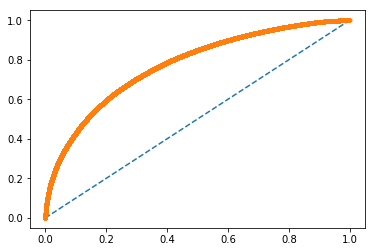


Confusion Matrix: 
 [[50330 49610]
 [50533 49128]]

              precision    recall  f1-score   support

     Class_0       0.50      0.50      0.50     99940
     Class_1       0.50      0.49      0.50     99661

   micro avg       0.50      0.50      0.50    199601
   macro avg       0.50      0.50      0.50    199601
weighted avg       0.50      0.50      0.50    199601



In [328]:
#Get AUC and create ROC from random forest built with pca
# predict probabilities
probs_rforest_pca = rand_forest_pca.predict_proba(test_X_PCA)
# keep probabilities for the positive outcome only
probs_rforest_pca = probs_rforest_pca[:, 1]
# calculate AUC
rforest_auc = roc_auc_score(test_Y_PCA, probs_rforest_pca)
print('AUC Score: %.3f' % rforest_auc)
# calculate roc curve
fpr_rforest_pca, tpr_rforest_pca, thresholds_rforest_pca = roc_curve(test_Y_PCA, probs_rforest_pca)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_rforest_pca, tpr_rforest_pca, marker='.')
# show the plot
plt.show()
print()


# create confusion matrix for random forest and PCA
print("Confusion Matrix: \n", confusion_matrix(test_Y_PCA, y_pred_rforest_pca))
print()

# perform classification report of the logistic regression model
class_names = ['Class_0', 'Class_1']
rforest_report_pca = classification_report(test_Y_PCA, y_pred_rforest_pca, target_names=class_names)
print(rforest_report_pca)

# KNN

In [330]:
# perform grid search to find the optimal parameters for our KNN model using full data.
KNN_model = KNeighborsClassifier()
KNN_params = {'n_neighbors':[5,10,15], 'weights':['uniform', 'distance']}
KNN_grid = GridSearchCV(KNN_model, KNN_params, cv=10, verbose=3)
KNN_grid.fit(train_X_FullDataSmall, train_Y_FullDataSmall)
print('Best parameters for data:', KNN_grid.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=5, weights=uniform, score=0.6067016265220869, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  n_neighbors=5, weights=uniform, score=0.6049240067549552, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s


[CV]  n_neighbors=5, weights=uniform, score=0.6107012709981335, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6018131721624744, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6123555555555555, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6058666666666667, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6060983198506534, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.604587074406614, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6055649391056983, total=   0.2s
[CV] n_neighbors=5, weights=u

[CV]  n_neighbors=15, weights=distance, score=0.6150768957240643, total=   0.3s
[CV] n_neighbors=15, weights=distance ................................
[CV]  n_neighbors=15, weights=distance, score=0.6150768957240643, total=   0.2s
[CV] n_neighbors=15, weights=distance ................................
[CV]  n_neighbors=15, weights=distance, score=0.609920881856165, total=   0.3s
Best parameters for data: {'n_neighbors': 15, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.0min finished


In [125]:
#initialize and train our model using full features
KNN = KNeighborsClassifier(n_neighbors=15, weights='uniform')

#set start time
starttime_knn = datetime.datetime.now()

#fit and train the model
KNN.fit(train_X,train_Y)

#Make predictions using test_X, and store results in new variable
y_pred_KNN = KNN.predict(test_X)

print('Accuracy score for KNN Model: ' + str(metrics.accuracy_score(test_Y, y_pred_KNN)))

#calculate end time
endtime_knn = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(endtime_knn - starttime_knn))
print()


KNN_cvs = cross_val_score(KNN, df_X, Y, cv=5, scoring='accuracy')
print(KNN_cvs)
print('Average cross validated score from our KNN model is: ' + str(np.mean(KNN_cvs)))


Accuracy score for KNN Model: 0.6446610988922902

Duration: 0:00:11.443412

[0.64595884 0.64572713 0.64475827 0.64651177 0.64449524]
Average cross validated score from our KNN model is: 0.6454902512876356


AUC Score: 0.700


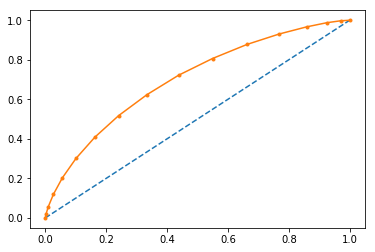

              precision    recall  f1-score   support

     Class_0       0.64      0.67      0.65     99261
     Class_1       0.65      0.62      0.64    100340

   micro avg       0.64      0.64      0.64    199601
   macro avg       0.65      0.64      0.64    199601
weighted avg       0.65      0.64      0.64    199601

Confusion Matrix: 
 [[66095 33166]
 [37760 62580]]


In [163]:
#Get AUC and create ROC
# predict probabilities
probs_KNN = KNN.predict_proba(test_X)
# keep probabilities for the positive outcome only
probs_KNN = probs_KNN[:, 1]
# calculate AUC
KNN_auc = roc_auc_score(test_Y, probs_KNN)
print('AUC Score: %.3f' % KNN_auc)
# calculate roc curve
fpr_KNN, tpr_KNN, thresholds_KNN = roc_curve(test_Y, probs_KNN)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_KNN, tpr_KNN, marker='.')
# show the plot
plt.show()

# perform classification report of the KNN model
class_names = ['Class_0', 'Class_1']
KNN_report = classification_report(test_Y, y_pred_KNN, target_names=class_names)
print(KNN_report)

# confusion Matrix
print("Confusion Matrix: \n", confusion_matrix(test_Y, y_pred_KNN))




## KNN with PCA

In [336]:
# perform grid search to find the optimal parameters for our KNN model using full data.
KNN_model_pca = KNeighborsClassifier()
KNN_params = {'n_neighbors':[5,10,15], 'weights':['uniform', 'distance']}
KNN_grid_pca = GridSearchCV(KNN_model, KNN_params, cv=10, verbose=3)
KNN_grid_pca.fit(train_X_SmallPCA, train_Y_SmallPCA)
print('Best parameters for data:', KNN_grid_pca.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=5, weights=uniform, score=0.6358909406039598, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV] ..... n_neighbors=5, weights=uniform, score=0.6302, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s


[CV] ..... n_neighbors=5, weights=uniform, score=0.6346, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6334666666666666, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ..... n_neighbors=5, weights=uniform, score=0.6388, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6385333333333333, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6384666666666666, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV]  n_neighbors=5, weights=uniform, score=0.6362666666666666, total=   0.2s
[CV] n_neighbors=5, weights=uniform ..................................
[CV] ..... n_neighbors=5, weights=uniform, score=0.6458, total=   0.2s
[CV] n_neighbors=5, weights=uniform .............

[CV]  n_neighbors=15, weights=distance, score=0.6401333333333333, total=   0.4s
[CV] n_neighbors=15, weights=distance ................................
[CV]  n_neighbors=15, weights=distance, score=0.6321754783652244, total=   0.4s
Best parameters for data: {'n_neighbors': 15, 'weights': 'uniform'}


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.0min finished


In [161]:
#initialize and train our model using the training set
KNN_pca = KNeighborsClassifier(n_neighbors=15, weights='uniform')

#set start time
starttime_knn = datetime.datetime.now()

#fit and train the model
KNN_pca.fit(train_X_PCA,train_Y_PCA)

#Make predictions using test_X, and store results in new variable
y_pred_KNN_pca = KNN_pca.predict(test_X_PCA)

print('Accuracy score for KNN Model: ' + str(metrics.accuracy_score(test_Y_PCA, y_pred_KNN_pca)))

#calculate end time
endtime_knn = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(endtime_knn - starttime_knn))
print()


KNN_cvs_pca = cross_val_score(KNN_pca, pca_df, Y, cv=5, scoring='accuracy')
print(KNN_cvs_pca)
print('Average cross validated score from our KNN model is: ' + str(np.mean(KNN_cvs_pca)))


Accuracy score for KNN Model: 0.6674966558283776

Duration: 0:00:05.926132

[0.66665623 0.66637442 0.66568763 0.66816759 0.66534319]
Average cross validated score from our KNN model is: 0.6664458090414618


AUC Score: 0.725


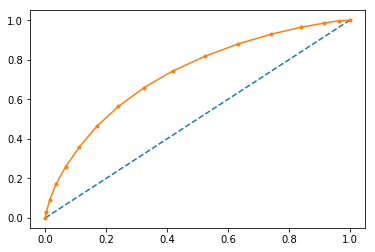

              precision    recall  f1-score   support

     Class_0       0.67      0.68      0.67    100167
     Class_1       0.67      0.66      0.66     99434

   micro avg       0.67      0.67      0.67    199601
   macro avg       0.67      0.67      0.67    199601
weighted avg       0.67      0.67      0.67    199601

Confusion Matrix: 
 [[67682 32485]
 [33883 65551]]


In [164]:
#Get AUC and create ROC
# predict probabilities
probs_KNN_pca = KNN_pca.predict_proba(test_X_PCA)
# keep probabilities for the positive outcome only
probs_KNN_pca = probs_KNN_pca[:, 1]
# calculate AUC
KNN_pca_auc = roc_auc_score(test_Y_PCA, probs_KNN_pca)
print('AUC Score: %.3f' % KNN_pca_auc)
# calculate roc curve
fpr_KNN_pca, tpr_KNN_pca, thresholds_KNN_pca = roc_curve(test_Y_PCA, probs_KNN_pca)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_KNN_pca, tpr_KNN_pca, marker='.')
# show the plot
plt.show()

# perform classification report of the KNN model
class_names = ['Class_0', 'Class_1']
KNN_report_pca = classification_report(test_Y_PCA, y_pred_KNN_pca, target_names=class_names)
print(KNN_report_pca)

# confusion Matrix
print("Confusion Matrix: \n", confusion_matrix(test_Y_PCA, y_pred_KNN_pca))



In [ ]:
# perform grid search to find the optimal parameters for our KNN model using full data.
KNN_model = KNeighborsClassifier()
KNN_params = {'n_neighbors':[5,10,15], 'weights':['uniform', 'distance']}
KNN_grid = GridSearchCV(KNN_model, KNN_params, cv=5)
KNN_grid.fit(train_X, train_Y)
print('Best parameters for data:', KNN_grid.best_params_)

# Gradient Boosting

In [134]:
#Run gridsearchcv to find the best parameters for gradient boosting using PCA
gboost_param_grid = {'n_estimators':[200], 'max_depth':[8,10,12], 'min_samples_leaf': [5, 8], 
                     'learning_rate': [.01, .02], 'subsample': [.7, .8]}
gb_model = ensemble.GradientBoostingClassifier(random_state=67)

gb_grid = GridSearchCV(gb_model, gboost_param_grid, cv=10, verbose=3)
gb_grid.fit(train_X_SmallPCA, train_Y_SmallPCA)
print('Best parameters for Gradient Boost Model are:', gb_grid.best_params_)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6585560962602494, total= 1.6min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6622225184987668, total= 1.6min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6556896206919539, total= 1.6min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6585333333333333, total= 1.6min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6615333333333333, total= 1.6min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6569333333333334, total= 1.6min
[CV] learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=8, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.65973333

[CV]  learning_rate=0.01, max_depth=10, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6654223051796547, total= 3.5min
[CV] learning_rate=0.01, max_depth=10, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=10, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6675554963002467, total= 3.5min
[CV] learning_rate=0.01, max_depth=10, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=10, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6600893273781748, total= 3.5min
[CV] learning_rate=0.01, max_depth=10, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=10, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6631333333333334, total= 3.5min
[CV] learning_rate=0.01, max_depth=10, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=10, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0

[CV]  learning_rate=0.01, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6589105940396026, total= 3.5min
[CV] learning_rate=0.01, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6631108740582705, total= 3.5min
[CV] learning_rate=0.01, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6620441362757518, total= 3.5min
[CV] learning_rate=0.01, max_depth=12, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=12, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0.6686887540830612, total= 7.0min
[CV] learning_rate=0.01, max_depth=12, min_samples_leaf=5, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.01, max_depth=12, min_samples_leaf=5, n_estimators=200, subsample=0.7, score=0

[CV]  learning_rate=0.01, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6711333333333334, total= 6.6min
[CV] learning_rate=0.01, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6656666666666666, total= 6.7min
[CV] learning_rate=0.01, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.669, total= 6.6min
[CV] learning_rate=0.01, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6635775718381225, total= 6.7min
[CV] learning_rate=0.01, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.01, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.662110807387

[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6664889007399507, total= 1.5min
[CV] learning_rate=0.02, max_depth=8, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6604893007132858, total= 1.5min
[CV] learning_rate=0.02, max_depth=8, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6662666666666667, total= 1.5min
[CV] learning_rate=0.02, max_depth=8, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6653333333333333, total= 1.5min
[CV] learning_rate=0.02, max_depth=8, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=8, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.66366666

[CV]  learning_rate=0.02, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.7, score=0.6638442562837522, total= 2.8min
[CV] learning_rate=0.02, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.7, score=0.6687779185279019, total= 2.7min
[CV] learning_rate=0.02, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6677554829678022, total= 2.9min
[CV] learning_rate=0.02, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0.6706219585360976, total= 2.9min
[CV] learning_rate=0.02, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8 
[CV]  learning_rate=0.02, max_depth=10, min_samples_leaf=8, n_estimators=200, subsample=0.8, score=0

[CV]  learning_rate=0.02, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.7, score=0.6684, total= 4.7min
[CV] learning_rate=0.02, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.7, score=0.6686, total= 4.7min
[CV] learning_rate=0.02, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.7, score=0.6647109807320488, total= 4.7min
[CV] learning_rate=0.02, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.7, score=0.665844389625975, total= 4.8min
[CV] learning_rate=0.02, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.7 
[CV]  learning_rate=0.02, max_depth=12, min_samples_leaf=8, n_estimators=200, subsample=0.7, score=0.667711180745383, total= 

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 871.2min finished


Best parameters for Gradient Boost Model are: {'learning_rate': 0.02, 'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 200, 'subsample': 0.7}


In [135]:
print('Best parameters for Gradient Boost Model are:', gb_grid.best_params_)
print('Best score for Gradient Boost Model are:', gb_grid.best_score_)

Best parameters for Gradient Boost Model are: {'learning_rate': 0.02, 'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 200, 'subsample': 0.7}
Best score for Gradient Boost Model are: 0.6679866666666666


In [117]:
# Initialize and fit the model using PCA
Grad_boost_pca = ensemble.GradientBoostingClassifier(learning_rate=0.02, max_depth=16, min_samples_leaf=5, 
                                                 n_estimators=200, subsample=0.7)

#set start time
start_time_gb = datetime.datetime.now()

#fit and train the model
Grad_boost_pca.fit(train_X_PCA, train_Y_PCA)

# Classify, storing the result in a new variable.
y_pred_Gboost_pca = Grad_boost_pca.predict(test_X_PCA)

#get accuracy score from our model
print('Accuracy score for Gradient Boost Model: ' + str(metrics.accuracy_score(test_Y_PCA, y_pred_Gboost_pca)))

#calculate end time
end_time_gb = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_gb - start_time_gb))
print()

#get average accuracy score using cross validation
#Grad_boost_cvs_pca = cross_val_score(Grad_boost_pca, pca_df, Y, cv=5, verbose=3, scoring='accuracy')
#print(Grad_boost_cvs_pca)

#print('Average cross validated score from our Gradient Boosting model is: ' + str(np.mean(Grad_boost_cvs_pca)))

Accuracy score for Gradient Boost Model: 0.680307212889715

Duration: 2:57:46.552538



AUC Score: 0.745


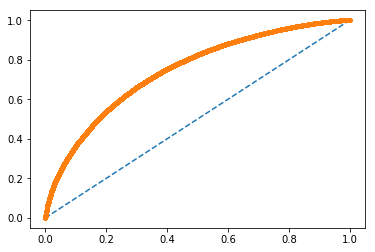

              precision    recall  f1-score   support

     Class_0       0.68      0.69      0.68    100167
     Class_1       0.68      0.67      0.68     99434

   micro avg       0.68      0.68      0.68    199601
   macro avg       0.68      0.68      0.68    199601
weighted avg       0.68      0.68      0.68    199601


Confusion Matrix:
[[68974 31193]
 [32618 66816]]


In [122]:
#Get AUC and create ROC
# predict probabilities
probs_Gboost_pca = Grad_boost_pca.predict_proba(test_X_PCA)
# keep probabilities for the positive outcome only
probs_Gboost_pca = probs_Gboost_pca[:, 1]
# calculate AUC
Gboost_auc = roc_auc_score(test_Y_PCA, probs_Gboost_pca)
print('AUC Score: %.3f' % Gboost_auc)
# calculate roc curve
fpr_Gboost_pca, tpr_Gboost_pca, thresholds_Gboost_pca = roc_curve(test_Y_PCA, probs_Gboost_pca)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_Gboost_pca, tpr_Gboost_pca, marker='.')
# show the plot
plt.show()

# perform classification report of the Gradient Boosting model
class_names = ['Class_0', 'Class_1']
Gboost_report = classification_report(test_Y_PCA, y_pred_Gboost_pca, target_names=class_names)
print(Gboost_report)
print()
#confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(test_Y_PCA, y_pred_Gboost_pca))

# SelectKBest

In [339]:
kbest = SelectKBest(f_classif)
pipeline = Pipeline([('kbest', kbest), ('lr', LogisticRegression())])
grid_search_kbest = GridSearchCV(pipeline, {'kbest__k': [1,2,3,4], 'lr__C': np.logspace(-10, 10, 5)})
grid_search_kbest.fit(train_X_FullDataSmall, train_Y_FullDataSmall)

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x0000016776187F28>)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kbest__k': [1, 2, 3, 4], 'lr__C': array([1.e-10, 1.e-05, 1.e+00, 1.e+05, 1.e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [340]:
print('Best parameters for Gradient Boost Model are:', grid_search_kbest.best_params_)
print('Best score for Gradient Boost Model are:', grid_search_kbest.best_score_)

Best parameters for Gradient Boost Model are: {'kbest__k': 4, 'lr__C': 100000.0}
Best score for Gradient Boost Model are: 0.6113866666666666


# Logistic Regression after tuning lambda

In [341]:
#initialize and train our model
LogReg2 = LogisticRegression(C=1e6)

#set start time
start_time4 = datetime.datetime.now()

#fit and train the model
LogReg2.fit(train_X, train_Y)

# Classify, storing the result in a new variable.
y_pred_LogReg2 = LogReg2.predict(test_X)

#get accuracy score from our model
print('Accuracy score for Logistic regression Model: ' + str(metrics.accuracy_score(test_Y, y_pred_LogReg2)))

#calculate end time
end_time4 = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time4 - start_time4))
print()

#get average accuracy score using cross validation
LogReg_cvs_new = cross_val_score(LogReg2, df_X, Y, cv=10, scoring='accuracy')
print(LogReg_cvs_new)

print('Average cross validated score from our log regression model is: ' + str(np.mean(LogReg_cvs_new)))

C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy score for Logistic regression Model: 0.6125821012920777

Duration: 0:00:15.494037



C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sajee\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linea

[0.60981689 0.61418802 0.61060872 0.6127004  0.6132014  0.61173597
 0.61391533 0.61392786 0.61282565 0.61307615]
Average cross validated score from our log regression model is: 0.6125996392662583


In [342]:
#applying selectKBest.
X_skb = SelectKBest(f_classif, k=6).fit_transform(df_X, Y)
print(X_skb.shape)

(798404, 6)


In [345]:
#After applying SelectKBest, I split the data into a third set of train and test groups
train_X_skb, test_X_skb, train_Y_skb, test_Y_skb = train_test_split(X_skb, Y, test_size=.3)

In [346]:
#initialize and train random forest model with full data
rand_forest_skb = ensemble.RandomForestClassifier(n_estimators=60, criterion='gini', max_depth=12, max_features=6,
                                              min_samples_split=10)

#set start time
start_time_rforest = datetime.datetime.now()

rand_forest_skb.fit(train_X_skb, train_Y_skb)

# Classify, storing the result in a new variable.
y_pred_rforest_skb = rand_forest_skb.predict(test_X_skb)

#get accuracy score from our model
print('Accuracy score for Random Forest Model: ' + str(metrics.accuracy_score(test_Y_skb, y_pred_rforest_skb)))

#calculate end time
end_time_rforest = datetime.datetime.now()

#print the execution run time for our model
print('\nDuration: {}'.format(end_time_rforest - start_time_rforest))
print()

#get average accuracy score of our random forest through cross validation
rforest_cvs_skb = cross_val_score(rand_forest_skb, X_skb, Y, cv=10, scoring='accuracy')
print(rforest_cvs_skb)
print('Average cross validated score from our Random Forest Model is: ' + str(np.mean(rforest_cvs_skb)))

Accuracy score for Random Forest Model: 0.6634087891717672

Duration: 0:01:49.843770

[0.66515117 0.66662909 0.66540581 0.66541834 0.66409068 0.66791082
 0.66352705 0.66624499 0.66409068 0.6685496 ]
Average cross validated score from our Random Forest Model is: 0.6657018241977305
